<a href="https://colab.research.google.com/github/ikathllen/SSVEP-Based-BCI-Epoch-Extraction-Analysis/blob/master/C%C3%B3digo_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Relatório de Pesquisa**

Neste trabalho, realizou-se o pré-processamento, a extração de características e a classificação dos sinais de eletroencefalograma (EEG), adquiridos utilizando o *Steady state visually evoked potential* (SSVEP), com o intuito de classificar os dados processados para identificar o estímulo visual ao qual o indivíduo está submetido, a fim de discriminar qual frequeência de estímulo o usuário está focado. Com base nisso, os módulos de extração e seleção de características de sinal serão implementados para criar cinco matrizes de atributos, que consiste em dividir cada *trial* de 15 segundos em épocas de 0,125 s, 0,250 s, 0,500 s, 1 s e 2 s. Os dados processados ​​serão então classificados utilizando técnicas como Análise Discriminante Linear (LDA) para comparar o desempenho das épocas. Desta forma, o trabalho atinge as etapas essenciais de uma BCI.

## **Aquisiçaõ de sinal**
*   Dataset: http://www.bakardjian.com/work/ssvep_data_Bakardjian.html
> O Dataset utilizado nesta pesquisa tem os direitos autorais da base de dados detidos pela RIKEN-LABSP e pelo Dr. Hovagim Bakardjian, e está disponível em um repositório de domínio público. O Dataset em questão possui dados de 3 frequências de estimulação SSVEP disponíveis (8 Hz, 14 Hz e 28 Hz) e sinais EEG de 4 sujeitos, sendo disponibilizados 5 arquivos distintos para cada frequência SSVEP de cada sujeito, representando os ensaios (trials). No experimento, a frequência de amostragem é de 256 Hz e a duração total do ensaio é de 24s, do qual o período de estímulo possui 15s cada trial que ocorre entre 5s e 20s.





In [ ]:
# importações padrão
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import numpy as np

# importação scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt, freqs
import scipy.io

# impotyação skelearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Driver do Cleison
# path_8Hz = '/content/drive/MyDrive/Fablena/Dataset_8hz/SSVEP_8Hz_Trial'
# path_14Hz = '/content/drive/MyDrive/Fablena/Dataset_14hz/SSVEP_14Hz_Trial'
# path_28Hz = '/content/drive/MyDrive/Fablena/Dataset_28hz/SSVEP_28Hz_Trial'

# # Driver da Fablena
path_8Hz = '/content/drive/MyDrive/Colab Notebooks/SSVEP/Fablena/Dataset_8hz/SSVEP_8Hz_Trial'
path_14Hz = '/content/drive/MyDrive/Colab Notebooks/SSVEP/Fablena/Dataset_14hz/SSVEP_14Hz_Trial'
path_28Hz = '/content/drive/MyDrive/Colab Notebooks/SSVEP/Fablena/Dataset_28hz/SSVEP_28Hz_Trial'

# Dados disponibilizados no Dataset
Fs = 256 # Frequencia de mostragem
tempo = 24 # Tempo total
qte_amostras = tempo*Fs # Quantidade de amostras

# No Dataset são disponibilizados 5 trials para cada frequência
trials = [1,2,3,4,5]

def carrega_dados(path, trials):
  '''
    Essa função carrega os dados que está no drive. Sendo que para cada pasta tem 5 trials.
    Args:
      path:(str) endereço onde está as pastas.
      trials:(list) lista da quantidade de arquivo que tem na pasta.
    Return:
      EEG:(ndarray) dados de EEG divididos em: número de canais,
      número de amostras e número de ensaios.
  '''
  for ind in trials:
    mat = scipy.io.loadmat( path + str(ind) + '_SUBJ1.MAT')
    mat = mat['EEGdata']
    mat = np.reshape(mat[:,0:qte_amostras], (128,qte_amostras, 1))
    if (ind==1):
      B = mat
    else:
      B = np.concatenate((B, mat), axis = 2)
  EEG = B
  return EEG

dados_8Hz = carrega_dados(path_8Hz, trials)
dados_14Hz = carrega_dados(path_14Hz, trials)
dados_28Hz = carrega_dados(path_28Hz, trials)


In [ ]:
dados_28Hz.shape

(128, 6144, 5)

## **Pré-Processamento**
A etapa de pré-processamento consiste em realizar a limpeza de ruídos do sinal.

### Filtro passa-faixas
> Para o pré-processamento de sinal, foram utilizadas duas funções: (1) O *butter()* que é utilizada para projetar filtros *Butterworth*, que são filtros passa-baixas, passa-altas, passa-faixas ou rejeita-faixas; (2) A *freqz()* que é utilizada para calcular a resposta em frequência de um sistema de filtragem, ambas as funções pertencem a biblioteca *scipy.signal*. Aplicou-se os sinais em um banco de filtros passa-faixas dirigido na frequência de cada estímulo com banda passante de 2 Hz.

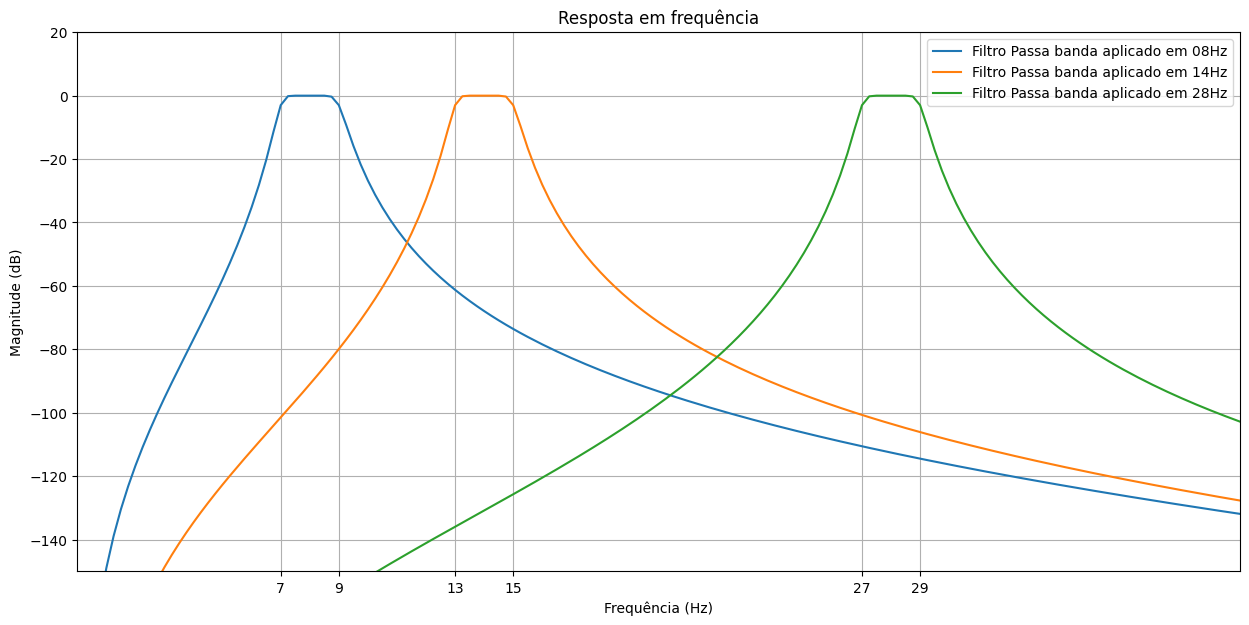

In [ ]:
# Definindo o filtro passa banda de 7Hz à 9Hz
b_08, a_08 = butter(5,[7, 9],'bandpass',fs = 256)
w_08 ,h_08 = freqz(b_08, a_08, fs = 256)

# Definindo o filtro passa banda de 13Hz à 15Hz
b_14, a_14 = butter(5,[13, 15],'bandpass',fs = 256)
w_14 ,h_14 = freqz(b_14, a_14, fs = 256)

# Definindo o filtro passa banda de 27Hz à 29Hz
b_28, a_28 = butter(5,[27, 29],'bandpass',fs = 256)
w_28 ,h_28 = freqz(b_28, a_28, fs = 256)

plt.figure(figsize=(15,7))
plt.title('Resposta em frequência')
plt.plot(w_08, 20*np.log10(np.abs(h_08)), label='Filtro Passa banda aplicado em 08Hz')
plt.plot(w_14, 20*np.log10(np.abs(h_14)), label='Filtro Passa banda aplicado em 14Hz')
plt.plot(w_28, 20*np.log10(np.abs(h_28)), label='Filtro Passa banda aplicado em 28Hz')
plt.xticks([7, 9, 13, 15, 27, 29])
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim([0, 40])
plt.ylim([-150, 20])
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
# Criando matriz de zeros para a remoção da média
dados_8Hz_removed_mean = np.zeros(dados_8Hz.shape)
dados_14Hz_removed_mean = np.zeros(dados_14Hz.shape)
dados_28Hz_removed_mean = np.zeros(dados_28Hz.shape)

# Criando matriz de zeros para os dados de 8Hz
dados_8Hz_filt_08Hz = np.zeros(dados_8Hz.shape)
dados_8Hz_filt_14Hz = np.zeros(dados_14Hz.shape)
dados_8Hz_filt_28Hz = np.zeros(dados_28Hz.shape)

# Criando matriz de zeros para os dados de 14Hz
dados_14Hz_filt_08Hz = np.zeros(dados_8Hz.shape)
dados_14Hz_filt_14Hz = np.zeros(dados_14Hz.shape)
dados_14Hz_filt_28Hz = np.zeros(dados_28Hz.shape)

# Criando matriz de zeros para os dados de 28Hz
dados_28Hz_filt_08Hz = np.zeros(dados_8Hz.shape)
dados_28Hz_filt_14Hz = np.zeros(dados_14Hz.shape)
dados_28Hz_filt_28Hz = np.zeros(dados_28Hz.shape)

# Laço para a quantidade de trials
for ind in range(5):
  # Laço para a quantidade de canais
  for channels in range(128):
    # Fazendo a retirada da média para aplicar o filtro
    dados_8Hz_removed_mean[channels, :, ind] = dados_8Hz[channels, :, ind] - np.mean(dados_8Hz[channels, :, ind])
    dados_14Hz_removed_mean[channels, :, ind] = dados_14Hz[channels, :, ind] - np.mean(dados_14Hz[channels, :, ind])
    dados_28Hz_removed_mean[channels, :, ind] = dados_28Hz[channels, :, ind] - np.mean(dados_28Hz[channels, :, ind])

# Laço para a quantidade de trials
for ind in range(5):
  # Laço para a quantidade de canais
  for channels in range(128):
    # Aplicando o filtro em cada canal dos 5 trials
    dados_8Hz_filt_08Hz[channels, :, ind] = lfilter(b_08, a_08, dados_8Hz_removed_mean[channels, :, ind]) # Dados de 8Hz filtrado em 8Hz
    dados_8Hz_filt_14Hz[channels, :, ind] = lfilter(b_14, a_14, dados_8Hz_removed_mean[channels, :, ind]) # Dados de 8Hz filtrado em 14Hz
    dados_8Hz_filt_28Hz[channels, :, ind] = lfilter(b_28, a_28, dados_8Hz_removed_mean[channels, :, ind]) # Dados de 8Hz filtrado em 28Hz

    dados_14Hz_filt_08Hz[channels, :, ind] = lfilter(b_08, a_08, dados_14Hz_removed_mean[channels, :, ind]) # Dados de 14Hz filtrado em 8Hz
    dados_14Hz_filt_14Hz[channels, :, ind] = lfilter(b_14, a_14, dados_14Hz_removed_mean[channels, :, ind]) # Dados de 14Hz filtrado em 14Hz
    dados_14Hz_filt_28Hz[channels, :, ind] = lfilter(b_28, a_28, dados_14Hz_removed_mean[channels, :, ind]) # Dados de 14Hz filtrado em 28Hz

    dados_28Hz_filt_08Hz[channels, :, ind] = lfilter(b_08, a_08, dados_28Hz_removed_mean[channels, :, ind]) # Dados de 28Hz filtrado em 8Hz
    dados_28Hz_filt_14Hz[channels, :, ind] = lfilter(b_14, a_14, dados_28Hz_removed_mean[channels, :, ind]) # Dados de 28Hz filtrado em 14Hz
    dados_28Hz_filt_28Hz[channels, :, ind] = lfilter(b_28, a_28, dados_28Hz_removed_mean[channels, :, ind]) # Dados de 28Hz filtrado em 28Hz


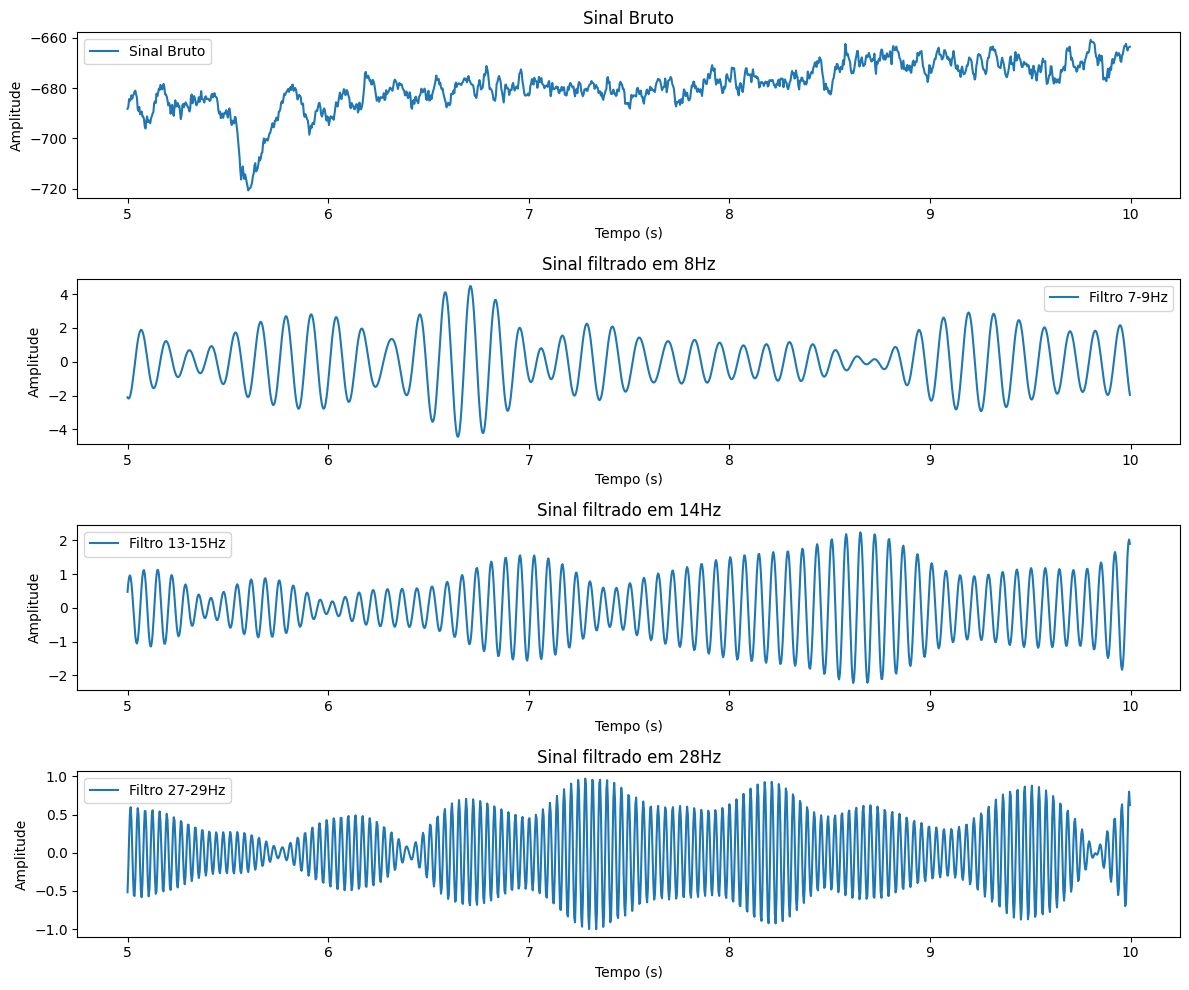

In [ ]:
# Canal e trial desejados
canal = 22
trial = 3

# Tempo de interesse
fs = 256  # Taxa de amostragem
tempo_inicio = 5 * fs
tempo_fim = 10 * fs

# Extração dos dados para o canal e trial específicos no intervalo de tempo
sinal_bruto = dados_8Hz[canal, tempo_inicio:tempo_fim, trial]
sinal_filtrado_08Hz = dados_8Hz_filt_08Hz[canal, tempo_inicio:tempo_fim, trial]
sinal_filtrado_14Hz = dados_14Hz_filt_14Hz[canal, tempo_inicio:tempo_fim, trial]
sinal_filtrado_28Hz = dados_28Hz_filt_28Hz[canal, tempo_inicio:tempo_fim, trial]

# Criação do vetor de tempo em segundos
tempo_segundos = np.arange(tempo_inicio / fs, tempo_fim / fs, 1 / fs)

# Plotagem dos sinais no domínio do tempo
plt.figure(figsize=(12, 10))

# Sinal Bruto
plt.subplot(4, 1, 1)
plt.plot(tempo_segundos, sinal_bruto, label='Sinal Bruto')
plt.title('Sinal Bruto')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()

# Filtro 8Hz
plt.subplot(4, 1, 2)
plt.plot(tempo_segundos, sinal_filtrado_08Hz, label='Filtro 7-9Hz')
plt.title('Sinal filtrado em 8Hz')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()

# Filtro 14Hz
plt.subplot(4, 1, 3)
plt.plot(tempo_segundos, sinal_filtrado_14Hz, label='Filtro 13-15Hz')
plt.title('Sinal filtrado em 14Hz')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()

# Filtro 28Hz
plt.subplot(4, 1, 4)
plt.plot(tempo_segundos, sinal_filtrado_28Hz, label='Filtro 27-29Hz')
plt.title('Sinal filtrado em 28Hz')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


## **Extração de Característica**
Nessa etapa, são aplicadas técnicas com o intuito de obter informações seguras dos sinais adquiridos para o processo de classificação.


### Extração de épocas
> A etapa após a filtragem do sinal é a que consiste em dividir os dados filtrados em pequenas janelas de tempo para analise. No dataset, ofernecido pelo pelo Dr. Hovagim Bakardjian, mostra que o período onde ocorre o estimulação visual é no intervalo de 5s à 20s, isso possibilita dizer que a duração do estímulo é de 15 segundos para cada trial. Diante dessa observação, o sinal foi divido para a criação de quatro matrizes de atributos com comprimentos de janela diferentes, que foram: 0,125 s, 0,250 s, 0,500 s, 1 s e 2 s (épocas). Outrossim, o dataset possui 5 trials e cada época será multiplicada pela quantidade dos trials, deste modo, para a janela de 0,125 segundo foram obtidas 600 épocas; para a janela de 0.250 segundos foram 300 épocas; para 0.500 segundos obteve-se 150 épocas; para a janela de 1 segundo foram 75 épocas; e por fim para a janela de 2 segundo foram 35 épocas.

In [ ]:
# canais, samples, trials = dados_14Hz_filt_14Hz.shape

def extrair_epocas(dados, tempo):
  '''
    Essa função pega o tempo total de estimulo (de 5s à 20s, definido no readme do dataset) e divide em épocas de 0,125 s, 0,250 s, 0,500 s e 1 s.
    Args:
      dados:(ndarray) dados de EEG divididos em: número de canais,
      número de amostras e número de ensaios.
      tempo: (int/float) época de 1s, 500ms, 250ms ou 125ms.
    Return:
      EEG:(ndarray) dados de EEG divididos em: número de canais,
      número de amostras e número de ensaios.
  '''
  canais, __, _ = dados.shape
  Fs = 256

  if (tempo == 2):
    epocas = np.ones((canais, Fs*2, 7*5))
    k = 0
    for trials in np.arange(1,6):
      for ind in np.arange(6, 20, 2):
        # print(ind)
        epocas[:, :, k] = dados[:, ind*Fs:((ind+2)*Fs), trials-1]
        k = k + 1
  if (tempo == 1):
    epocas = np.ones((canais, Fs, 15*5))
    k = 0
    for trials in np.arange(1,6):
      for ind in np.arange(6,21):
        epocas[:, :, k] = dados[:, ind*Fs:((ind+1)*Fs), trials-1]
        k = k + 1
  if (tempo == 0.5):
    epocas = np.ones((canais, int(Fs/2), 30*5))
    # trechos =
    k = 0
    for trials in np.arange(1,6):
      for ind in np.arange(6,21):
        soma = 0
        for div in np.arange(1, 3):
          epocas[:, :, k] = dados[:, ((ind*Fs)+soma):((ind*Fs)+(soma+128)), trials-1]
          soma += 128
          k = k + 1
  if (tempo == 0.25):
    epocas = np.ones((canais, int(Fs/4), 60*5))
    # trechos =
    k = 0
    for trials in np.arange(1,6):
      for ind in np.arange(6,21):
        soma = 0
        for div in np.arange(1, 5):
          epocas[:, :, k] = dados[:, ((ind*Fs)+soma):((ind*Fs)+(soma+64)), trials-1]
          soma += 64
          k = k + 1
  if (tempo == 0.125):
    epocas = np.ones((canais, int(Fs/8), 120*5))
    # trechos =
    k = 0
    for trials in np.arange(1,6):
      for ind in np.arange(6,21):
        soma = 0
        for div in np.arange(1, 9):
          epocas[:, :, k] = dados[:, ((ind*Fs)+soma):((ind*Fs)+(soma+32)), trials-1]
          soma += 32
          k = k + 1
  return epocas

epocas_2s_8Hz_filt_08Hz = extrair_epocas(dados_8Hz_filt_08Hz, 2)
epocas_2s_8Hz_filt_14Hz = extrair_epocas(dados_8Hz_filt_14Hz, 2)
epocas_2s_8Hz_filt_28Hz = extrair_epocas(dados_8Hz_filt_28Hz, 2)
epocas_2s_14Hz_filt_08Hz = extrair_epocas(dados_14Hz_filt_08Hz, 2)
epocas_2s_14Hz_filt_14Hz = extrair_epocas(dados_14Hz_filt_14Hz, 2)
epocas_2s_14Hz_filt_28Hz = extrair_epocas(dados_14Hz_filt_28Hz, 2)
epocas_2s_28Hz_filt_08Hz = extrair_epocas(dados_28Hz_filt_08Hz, 2)
epocas_2s_28Hz_filt_14Hz = extrair_epocas(dados_28Hz_filt_14Hz, 2)
epocas_2s_28Hz_filt_28Hz = extrair_epocas(dados_28Hz_filt_28Hz, 2)

epocas_1s_8Hz_filt_08Hz = extrair_epocas(dados_8Hz_filt_08Hz, 1)
epocas_1s_8Hz_filt_14Hz = extrair_epocas(dados_8Hz_filt_14Hz, 1)
epocas_1s_8Hz_filt_28Hz = extrair_epocas(dados_8Hz_filt_28Hz, 1)
epocas_1s_14Hz_filt_08Hz = extrair_epocas(dados_14Hz_filt_08Hz, 1)
epocas_1s_14Hz_filt_14Hz = extrair_epocas(dados_14Hz_filt_14Hz, 1)
epocas_1s_14Hz_filt_28Hz = extrair_epocas(dados_14Hz_filt_28Hz, 1)
epocas_1s_28Hz_filt_08Hz = extrair_epocas(dados_28Hz_filt_08Hz, 1)
epocas_1s_28Hz_filt_14Hz = extrair_epocas(dados_28Hz_filt_14Hz, 1)
epocas_1s_28Hz_filt_28Hz = extrair_epocas(dados_28Hz_filt_28Hz, 1)

epocas_500ms_8Hz_filt_08Hz = extrair_epocas(dados_8Hz_filt_08Hz, 0.5)
epocas_500ms_8Hz_filt_14Hz = extrair_epocas(dados_8Hz_filt_14Hz, 0.5)
epocas_500ms_8Hz_filt_28Hz = extrair_epocas(dados_8Hz_filt_28Hz, 0.5)
epocas_500ms_14Hz_filt_08Hz = extrair_epocas(dados_14Hz_filt_08Hz, 0.5)
epocas_500ms_14Hz_filt_14Hz = extrair_epocas(dados_14Hz_filt_14Hz, 0.5)
epocas_500ms_14Hz_filt_28Hz = extrair_epocas(dados_14Hz_filt_28Hz, 0.5)
epocas_500ms_28Hz_filt_08Hz = extrair_epocas(dados_28Hz_filt_08Hz, 0.5)
epocas_500ms_28Hz_filt_14Hz = extrair_epocas(dados_28Hz_filt_14Hz, 0.5)
epocas_500ms_28Hz_filt_28Hz = extrair_epocas(dados_28Hz_filt_28Hz, 0.5)

epocas_250ms_8Hz_filt_08Hz = extrair_epocas(dados_8Hz_filt_08Hz, 0.25)
epocas_250ms_8Hz_filt_14Hz = extrair_epocas(dados_8Hz_filt_14Hz, 0.25)
epocas_250ms_8Hz_filt_28Hz = extrair_epocas(dados_8Hz_filt_28Hz, 0.25)
epocas_250ms_14Hz_filt_08Hz = extrair_epocas(dados_14Hz_filt_08Hz, 0.25)
epocas_250ms_14Hz_filt_14Hz = extrair_epocas(dados_14Hz_filt_14Hz, 0.25)
epocas_250ms_14Hz_filt_28Hz = extrair_epocas(dados_14Hz_filt_28Hz, 0.25)
epocas_250ms_28Hz_filt_08Hz = extrair_epocas(dados_28Hz_filt_08Hz, 0.25)
epocas_250ms_28Hz_filt_14Hz = extrair_epocas(dados_28Hz_filt_14Hz, 0.25)
epocas_250ms_28Hz_filt_28Hz = extrair_epocas(dados_28Hz_filt_28Hz, 0.25)

epocas_125ms_8Hz_filt_08Hz = extrair_epocas(dados_8Hz_filt_08Hz, 0.125)
epocas_125ms_8Hz_filt_14Hz = extrair_epocas(dados_8Hz_filt_14Hz, 0.125)
epocas_125ms_8Hz_filt_28Hz = extrair_epocas(dados_8Hz_filt_28Hz, 0.125)
epocas_125ms_14Hz_filt_08Hz = extrair_epocas(dados_14Hz_filt_08Hz, 0.125)
epocas_125ms_14Hz_filt_14Hz = extrair_epocas(dados_14Hz_filt_14Hz, 0.125)
epocas_125ms_14Hz_filt_28Hz = extrair_epocas(dados_14Hz_filt_28Hz, 0.125)
epocas_125ms_28Hz_filt_08Hz = extrair_epocas(dados_28Hz_filt_08Hz, 0.125)
epocas_125ms_28Hz_filt_14Hz = extrair_epocas(dados_28Hz_filt_14Hz, 0.125)
epocas_125ms_28Hz_filt_28Hz = extrair_epocas(dados_28Hz_filt_28Hz, 0.125)

In [ ]:
print(epocas_125ms_8Hz_filt_08Hz.shape)
print(epocas_250ms_8Hz_filt_08Hz.shape)
print(epocas_500ms_8Hz_filt_08Hz.shape)
print(epocas_1s_8Hz_filt_08Hz.shape)
print(epocas_2s_8Hz_filt_08Hz.shape)

(128, 32, 600)
(128, 64, 300)
(128, 128, 150)
(128, 256, 75)
(128, 512, 35)


###Canal de interesse
> O esse tópico é para capturar o canal de interesse. O conjunto de dados disponibilizado é aquisitado utilizando um mapeamento de cabeça completo com 128 eletrodos(canais). Para observar o SSVEP é necessário apenas os eletrodos posicionados no lobo occiptal. Para este trabalho utilizou-se apenas um eletrodo localizado no lobo occiptal que é o princial(Oz).


In [ ]:
'''
  O dataset utilizado possui dados capturados de 128 eletrodos, isso é um mapeamento completo de cabeça.
  Para capturar o SSVEP é necessário apenas os eletrodos posicionados no lobo occiptal.
  Para este trabalho utilizamos apenas um eletrodo localizado no lobo occiptal que é o princial(Oz).
'''
# Canais de interesse
stimulus_channels = 25

# Canais com estímulo de 8Hz filtrado em 08Hz parada cada época
target_125ms_8Hz_filt_08Hz = epocas_125ms_8Hz_filt_08Hz[stimulus_channels,:,:]
target_250ms_8Hz_filt_08Hz = epocas_250ms_8Hz_filt_08Hz[stimulus_channels,:,:]
target_500ms_8Hz_filt_08Hz = epocas_500ms_8Hz_filt_08Hz[stimulus_channels,:,:]
target_1s_8Hz_filt_08Hz = epocas_1s_8Hz_filt_08Hz[stimulus_channels,:,:]
target_2s_8Hz_filt_08Hz = epocas_2s_8Hz_filt_08Hz[stimulus_channels,:,:]

# Canais com estímulo de 8Hz filtrado em 14Hz parada cada época
target_125ms_8Hz_filt_14Hz = epocas_125ms_8Hz_filt_14Hz[stimulus_channels,:,:]
target_250ms_8Hz_filt_14Hz = epocas_250ms_8Hz_filt_14Hz[stimulus_channels,:,:]
target_500ms_8Hz_filt_14Hz = epocas_500ms_8Hz_filt_14Hz[stimulus_channels,:,:]
target_1s_8Hz_filt_14Hz = epocas_1s_8Hz_filt_14Hz[stimulus_channels,:,:]
target_2s_8Hz_filt_14Hz = epocas_2s_8Hz_filt_14Hz[stimulus_channels,:,:]

# Canais com estímulo de 8Hz filtrado em 28Hz parada cada época
target_125ms_8Hz_filt_28Hz = epocas_125ms_8Hz_filt_28Hz[stimulus_channels,:,:]
target_250ms_8Hz_filt_28Hz = epocas_250ms_8Hz_filt_28Hz[stimulus_channels,:,:]
target_500ms_8Hz_filt_28Hz = epocas_500ms_8Hz_filt_28Hz[stimulus_channels,:,:]
target_1s_8Hz_filt_28Hz = epocas_1s_8Hz_filt_28Hz[stimulus_channels,:,:]
target_2s_8Hz_filt_28Hz = epocas_2s_8Hz_filt_28Hz[stimulus_channels,:,:]

# Canais com estímulo de 14Hz filtrado em 8Hz parada cada época
target_125ms_14Hz_filt_08Hz = epocas_125ms_14Hz_filt_08Hz[stimulus_channels,:,:]
target_250ms_14Hz_filt_08Hz = epocas_250ms_14Hz_filt_08Hz[stimulus_channels,:,:]
target_500ms_14Hz_filt_08Hz = epocas_500ms_14Hz_filt_08Hz[stimulus_channels,:,:]
target_1s_14Hz_filt_08Hz = epocas_1s_14Hz_filt_08Hz[stimulus_channels,:,:]
target_2s_14Hz_filt_08Hz = epocas_2s_14Hz_filt_08Hz[stimulus_channels,:,:]

# Canais com estímulo de 14Hz filtrado em 14Hz parada cada época
target_125ms_14Hz_filt_14Hz = epocas_125ms_14Hz_filt_14Hz[stimulus_channels,:,:]
target_250ms_14Hz_filt_14Hz = epocas_250ms_14Hz_filt_14Hz[stimulus_channels,:,:]
target_500ms_14Hz_filt_14Hz = epocas_500ms_14Hz_filt_14Hz[stimulus_channels,:,:]
target_1s_14Hz_filt_14Hz = epocas_1s_14Hz_filt_14Hz[stimulus_channels,:,:]
target_2s_14Hz_filt_14Hz = epocas_2s_14Hz_filt_14Hz[stimulus_channels,:,:]

# Canais com estímulo de 14Hz filtrado em 28Hz parada cada época
target_125ms_14Hz_filt_28Hz = epocas_125ms_14Hz_filt_28Hz[stimulus_channels,:,:]
target_250ms_14Hz_filt_28Hz = epocas_250ms_14Hz_filt_28Hz[stimulus_channels,:,:]
target_500ms_14Hz_filt_28Hz = epocas_500ms_14Hz_filt_28Hz[stimulus_channels,:,:]
target_1s_14Hz_filt_28Hz = epocas_1s_14Hz_filt_28Hz[stimulus_channels,:,:]
target_2s_14Hz_filt_28Hz = epocas_2s_14Hz_filt_28Hz[stimulus_channels,:,:]

# Canais com estímulo de 28Hz filtrado em 08Hz parada cada época
target_125ms_28Hz_filt_08Hz = epocas_125ms_28Hz_filt_08Hz[stimulus_channels,:,:]
target_250ms_28Hz_filt_08Hz = epocas_250ms_28Hz_filt_08Hz[stimulus_channels,:,:]
target_500ms_28Hz_filt_08Hz = epocas_500ms_28Hz_filt_08Hz[stimulus_channels,:,:]
target_1s_28Hz_filt_08Hz = epocas_1s_28Hz_filt_08Hz[stimulus_channels,:,:]
target_2s_28Hz_filt_08Hz = epocas_2s_28Hz_filt_08Hz[stimulus_channels,:,:]

# Canais com estímulo de 28Hz filtrado em 14Hz parada cada época
target_125ms_28Hz_filt_14Hz = epocas_125ms_28Hz_filt_14Hz[stimulus_channels,:,:]
target_250ms_28Hz_filt_14Hz = epocas_250ms_28Hz_filt_14Hz[stimulus_channels,:,:]
target_500ms_28Hz_filt_14Hz = epocas_500ms_28Hz_filt_14Hz[stimulus_channels,:,:]
target_1s_28Hz_filt_14Hz = epocas_1s_28Hz_filt_14Hz[stimulus_channels,:,:]
target_2s_28Hz_filt_14Hz = epocas_2s_28Hz_filt_14Hz[stimulus_channels,:,:]

# Canais com estímulo de 28Hz filtrado em 28Hz parada cada época
target_125ms_28Hz_filt_28Hz = epocas_125ms_28Hz_filt_28Hz[stimulus_channels,:,:]
target_250ms_28Hz_filt_28Hz = epocas_250ms_28Hz_filt_28Hz[stimulus_channels,:,:]
target_500ms_28Hz_filt_28Hz = epocas_500ms_28Hz_filt_28Hz[stimulus_channels,:,:]
target_1s_28Hz_filt_28Hz = epocas_1s_28Hz_filt_28Hz[stimulus_channels,:,:]
target_2s_28Hz_filt_28Hz = epocas_2s_28Hz_filt_28Hz[stimulus_channels,:,:]

In [ ]:
# Frequências
trial = 6

epoch = ['2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms', '2s', '1s', '500ms', '250ms', '125ms']
frequencias1 = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]
frequencia2 = [8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 28, 28, 28, 28, 28, 8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 28, 28, 28, 28, 28, 8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 28, 28, 28, 28, 28]

# Dados
dados = [
    target_125ms_8Hz_filt_08Hz[:, trial], target_250ms_8Hz_filt_08Hz[:, trial], target_500ms_8Hz_filt_08Hz[:, trial], target_1s_8Hz_filt_08Hz[:, trial], target_2s_8Hz_filt_08Hz[:, trial],
    target_125ms_8Hz_filt_14Hz[:, trial], target_250ms_8Hz_filt_14Hz[:, trial], target_500ms_8Hz_filt_14Hz[:, trial], target_1s_8Hz_filt_14Hz[:, trial], target_2s_8Hz_filt_14Hz[:, trial],
    target_125ms_8Hz_filt_28Hz[:, trial], target_250ms_8Hz_filt_28Hz[:, trial], target_500ms_8Hz_filt_28Hz[:, trial], target_1s_8Hz_filt_28Hz[:, trial], target_2s_8Hz_filt_28Hz[:, trial],
    target_125ms_14Hz_filt_08Hz[:, trial], target_250ms_14Hz_filt_08Hz[:, trial], target_500ms_14Hz_filt_08Hz[:, trial], target_1s_14Hz_filt_08Hz[:, trial], target_2s_14Hz_filt_08Hz[:, trial],
    target_125ms_14Hz_filt_14Hz[:, trial], target_250ms_14Hz_filt_14Hz[:, trial], target_500ms_14Hz_filt_14Hz[:, trial], target_1s_14Hz_filt_14Hz[:, trial], target_2s_14Hz_filt_14Hz[:, trial],
    target_125ms_14Hz_filt_28Hz[:, trial], target_250ms_14Hz_filt_28Hz[:, trial], target_500ms_14Hz_filt_28Hz[:, trial], target_1s_14Hz_filt_28Hz[:, trial], target_2s_14Hz_filt_28Hz[:, trial],
    target_125ms_28Hz_filt_08Hz[:, trial], target_250ms_28Hz_filt_08Hz[:, trial], target_500ms_28Hz_filt_08Hz[:, trial], target_1s_28Hz_filt_08Hz[:, trial], target_2s_28Hz_filt_08Hz[:, trial],
    target_125ms_28Hz_filt_14Hz[:, trial], target_250ms_28Hz_filt_14Hz[:, trial], target_500ms_28Hz_filt_14Hz[:, trial], target_1s_28Hz_filt_14Hz[:, trial], target_2s_28Hz_filt_14Hz[:, trial],
    target_125ms_28Hz_filt_28Hz[:, trial], target_250ms_28Hz_filt_28Hz[:, trial], target_500ms_28Hz_filt_28Hz[:, trial], target_1s_28Hz_filt_28Hz[:, trial], target_2s_28Hz_filt_28Hz[:, trial]
]

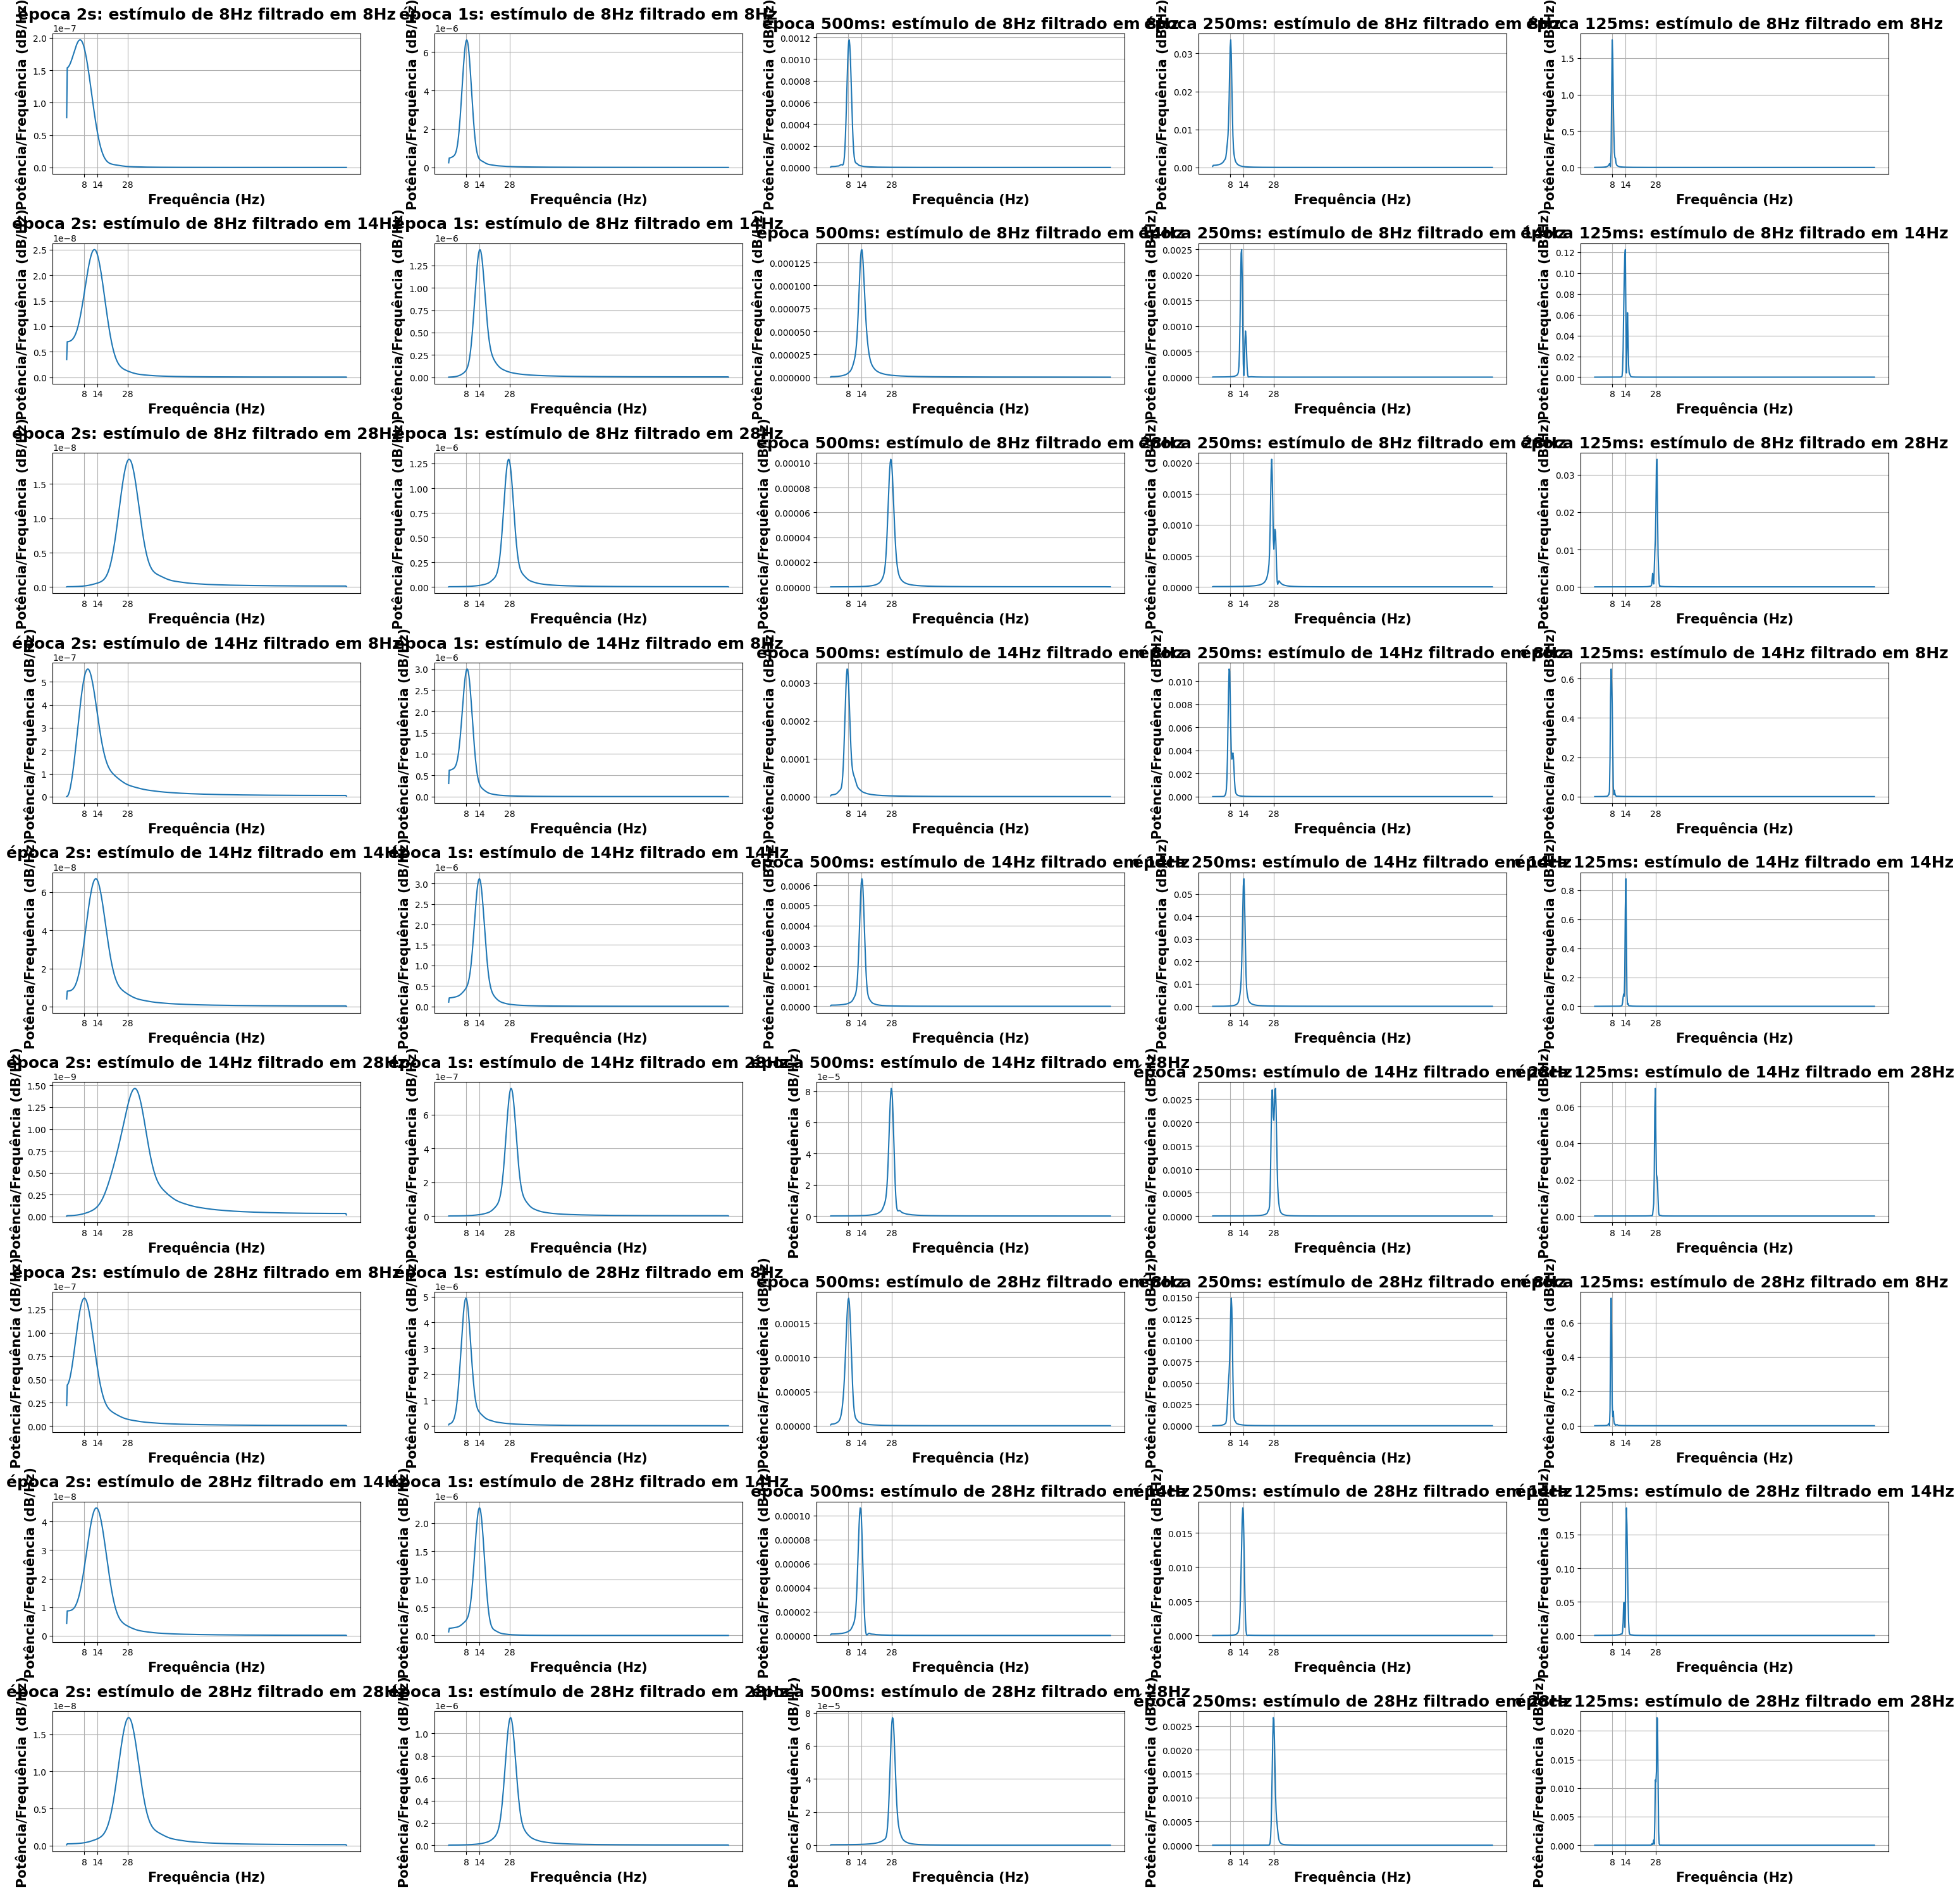

In [ ]:
# Crie um layout de subplots 9frequencias x 5épocas
fig, axs = plt.subplots(9, 5, figsize=(30, 30))

# Loop para calcular o PSD e plotar os gráficos
for i, dado in enumerate(dados):
    linha = i // 5
    coluna = i % 5

    # Calcular o PSD
    power, freq = psd(dado, NFFT=1024, Fs=fs, noverlap=512)

    # Plotar o gráfico
    axs[linha, coluna].plot(freq, power)

    # Definir o título
    axs[linha, coluna].set_title( f'época {epoch[i]}: estímulo de {frequencias1[i]}Hz filtrado em {frequencia2[i]}Hz',
                                 fontdict={'fontsize': 18, 'fontweight': 'bold'} )
    axs[linha, coluna].set_xlabel('Frequência (Hz)', fontdict={'fontsize': 15, 'fontweight': 'bold'})
    axs[linha, coluna].set_ylabel('Potência/Frequência (dB/Hz)', fontdict={'fontsize': 15, 'fontweight': 'bold'})
    axs[linha, coluna].set_xticks([8, 14, 28])
    axs[linha, coluna].grid()

# Ajustar o espaçamento entre os subplots
plt.tight_layout()
plt.show()


### Periodograma
> O periodograma é uma ferramenta útil para analisar sinais espectrais, pois mostra claramente as relações entre amplitude e frequência do sinal. Ele pode estimar a densidade espectral de potência de um sinal(PSD), que é uma técnica utilizada para a extração de características de sinais com resposta SSVEP. Para estimar a densidade espectral de potência do sinal, foi utilizada a função *periodogram()* da biblioteca *scipy.signal*. Essa função permite calcular o espectro de potência de um sinal a partir de sua série temporal. Após a aplicação do periodograma, a energia do sinal foi obtida utilizando a função *sum()* da biblioteca *numpy*. A energia é uma medida importante do sinal, que representa a quantidade total de energia contida no sinal em todas as suas frequências.


In [ ]:
def extraction_power(sinal, fs):
  '''
    Essa função realiza o periodograma e o soma dos elementos para obter a energia.
    Args:
      sinal:(ndarray) número de amostras e número de épocas.
      fs: (int) frequência de amostragem de cada época
    Return:
      power:(ndarray) valor da energia.
  '''
  _, trecho = sinal.shape
  # fs = 256
  power = np.zeros(trecho)
  for i in range(trecho):
    freqs, psd_ = signal.periodogram(sinal[:, i], fs, scaling='density')
    # freqs, psd_ = signal.welch(sinal[:, i], fs, nperseg=None)
    power[i] = np.sum(psd_)
  return power

power_125ms_8hz_filt_08Hz = extraction_power(target_125ms_8Hz_filt_08Hz, 32)
power_250ms_8hz_filt_08Hz = extraction_power(target_250ms_8Hz_filt_08Hz, 64 )
power_500ms_8hz_filt_08Hz = extraction_power(target_500ms_8Hz_filt_08Hz, 128)
power_1s_8hz_filt_08Hz = extraction_power(target_1s_8Hz_filt_08Hz, 256)
power_2s_8hz_filt_08Hz = extraction_power(target_2s_8Hz_filt_08Hz, 512)

power_125ms_8hz_filt_14Hz = extraction_power(target_125ms_8Hz_filt_14Hz, 32)
power_250ms_8hz_filt_14Hz = extraction_power(target_250ms_8Hz_filt_14Hz, 64 )
power_500ms_8hz_filt_14Hz = extraction_power(target_500ms_8Hz_filt_14Hz, 128)
power_1s_8hz_filt_14Hz = extraction_power(target_1s_8Hz_filt_14Hz, 256)
power_2s_8hz_filt_14Hz = extraction_power(target_2s_8Hz_filt_14Hz, 512)

power_125ms_8hz_filt_28Hz = extraction_power(target_125ms_8Hz_filt_28Hz, 32)
power_250ms_8hz_filt_28Hz = extraction_power(target_250ms_8Hz_filt_28Hz, 64 )
power_500ms_8hz_filt_28Hz = extraction_power(target_500ms_8Hz_filt_28Hz, 128)
power_1s_8hz_filt_28Hz = extraction_power(target_1s_8Hz_filt_28Hz, 256)
power_2s_8hz_filt_28Hz = extraction_power(target_2s_8Hz_filt_28Hz, 512)

power_125ms_14hz_filt_08Hz = extraction_power(target_125ms_14Hz_filt_08Hz, 32)
power_250ms_14hz_filt_08Hz = extraction_power(target_250ms_14Hz_filt_08Hz, 64)
power_500ms_14hz_filt_08Hz = extraction_power(target_500ms_14Hz_filt_08Hz, 128)
power_1s_14hz_filt_08Hz = extraction_power(target_1s_14Hz_filt_08Hz, 256)
power_2s_14hz_filt_08Hz = extraction_power(target_2s_14Hz_filt_08Hz, 512)

power_125ms_14hz_filt_14Hz = extraction_power(target_125ms_14Hz_filt_14Hz, 32)
power_250ms_14hz_filt_14Hz = extraction_power(target_250ms_14Hz_filt_14Hz, 64)
power_500ms_14hz_filt_14Hz = extraction_power(target_500ms_14Hz_filt_14Hz, 128)
power_1s_14hz_filt_14Hz = extraction_power(target_1s_14Hz_filt_14Hz, 256)
power_2s_14hz_filt_14Hz = extraction_power(target_2s_14Hz_filt_14Hz, 512)

power_125ms_14hz_filt_28Hz = extraction_power(target_125ms_14Hz_filt_28Hz, 32)
power_250ms_14hz_filt_28Hz = extraction_power(target_250ms_14Hz_filt_28Hz, 64)
power_500ms_14hz_filt_28Hz = extraction_power(target_500ms_14Hz_filt_28Hz, 128)
power_1s_14hz_filt_28Hz = extraction_power(target_1s_14Hz_filt_28Hz, 256)
power_2s_14hz_filt_28Hz = extraction_power(target_2s_14Hz_filt_28Hz, 512)

power_125ms_28hz_filt_08Hz = extraction_power(target_125ms_28Hz_filt_08Hz, 32)
power_250ms_28hz_filt_08Hz = extraction_power(target_250ms_28Hz_filt_08Hz, 64 )
power_500ms_28hz_filt_08Hz = extraction_power(target_500ms_28Hz_filt_08Hz, 128)
power_1s_28hz_filt_08Hz = extraction_power(target_1s_28Hz_filt_08Hz, 256)
power_2s_28hz_filt_08Hz = extraction_power(target_2s_28Hz_filt_08Hz, 512)

power_125ms_28hz_filt_14Hz = extraction_power(target_125ms_28Hz_filt_14Hz, 32)
power_250ms_28hz_filt_14Hz = extraction_power(target_250ms_28Hz_filt_14Hz, 64 )
power_500ms_28hz_filt_14Hz = extraction_power(target_500ms_28Hz_filt_14Hz, 128)
power_1s_28hz_filt_14Hz = extraction_power(target_1s_28Hz_filt_14Hz, 256)
power_2s_28hz_filt_14Hz = extraction_power(target_2s_28Hz_filt_14Hz, 512)

power_125ms_28hz_filt_28Hz = extraction_power(target_125ms_28Hz_filt_28Hz, 32)
power_250ms_28hz_filt_28Hz = extraction_power(target_250ms_28Hz_filt_28Hz, 64 )
power_500ms_28hz_filt_28Hz = extraction_power(target_500ms_28Hz_filt_28Hz, 128)
power_1s_28hz_filt_28Hz = extraction_power(target_1s_28Hz_filt_28Hz, 256)
power_2s_28hz_filt_28Hz = extraction_power(target_2s_28Hz_filt_28Hz, 512)


<ipython-input-14-17c85a658f17>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


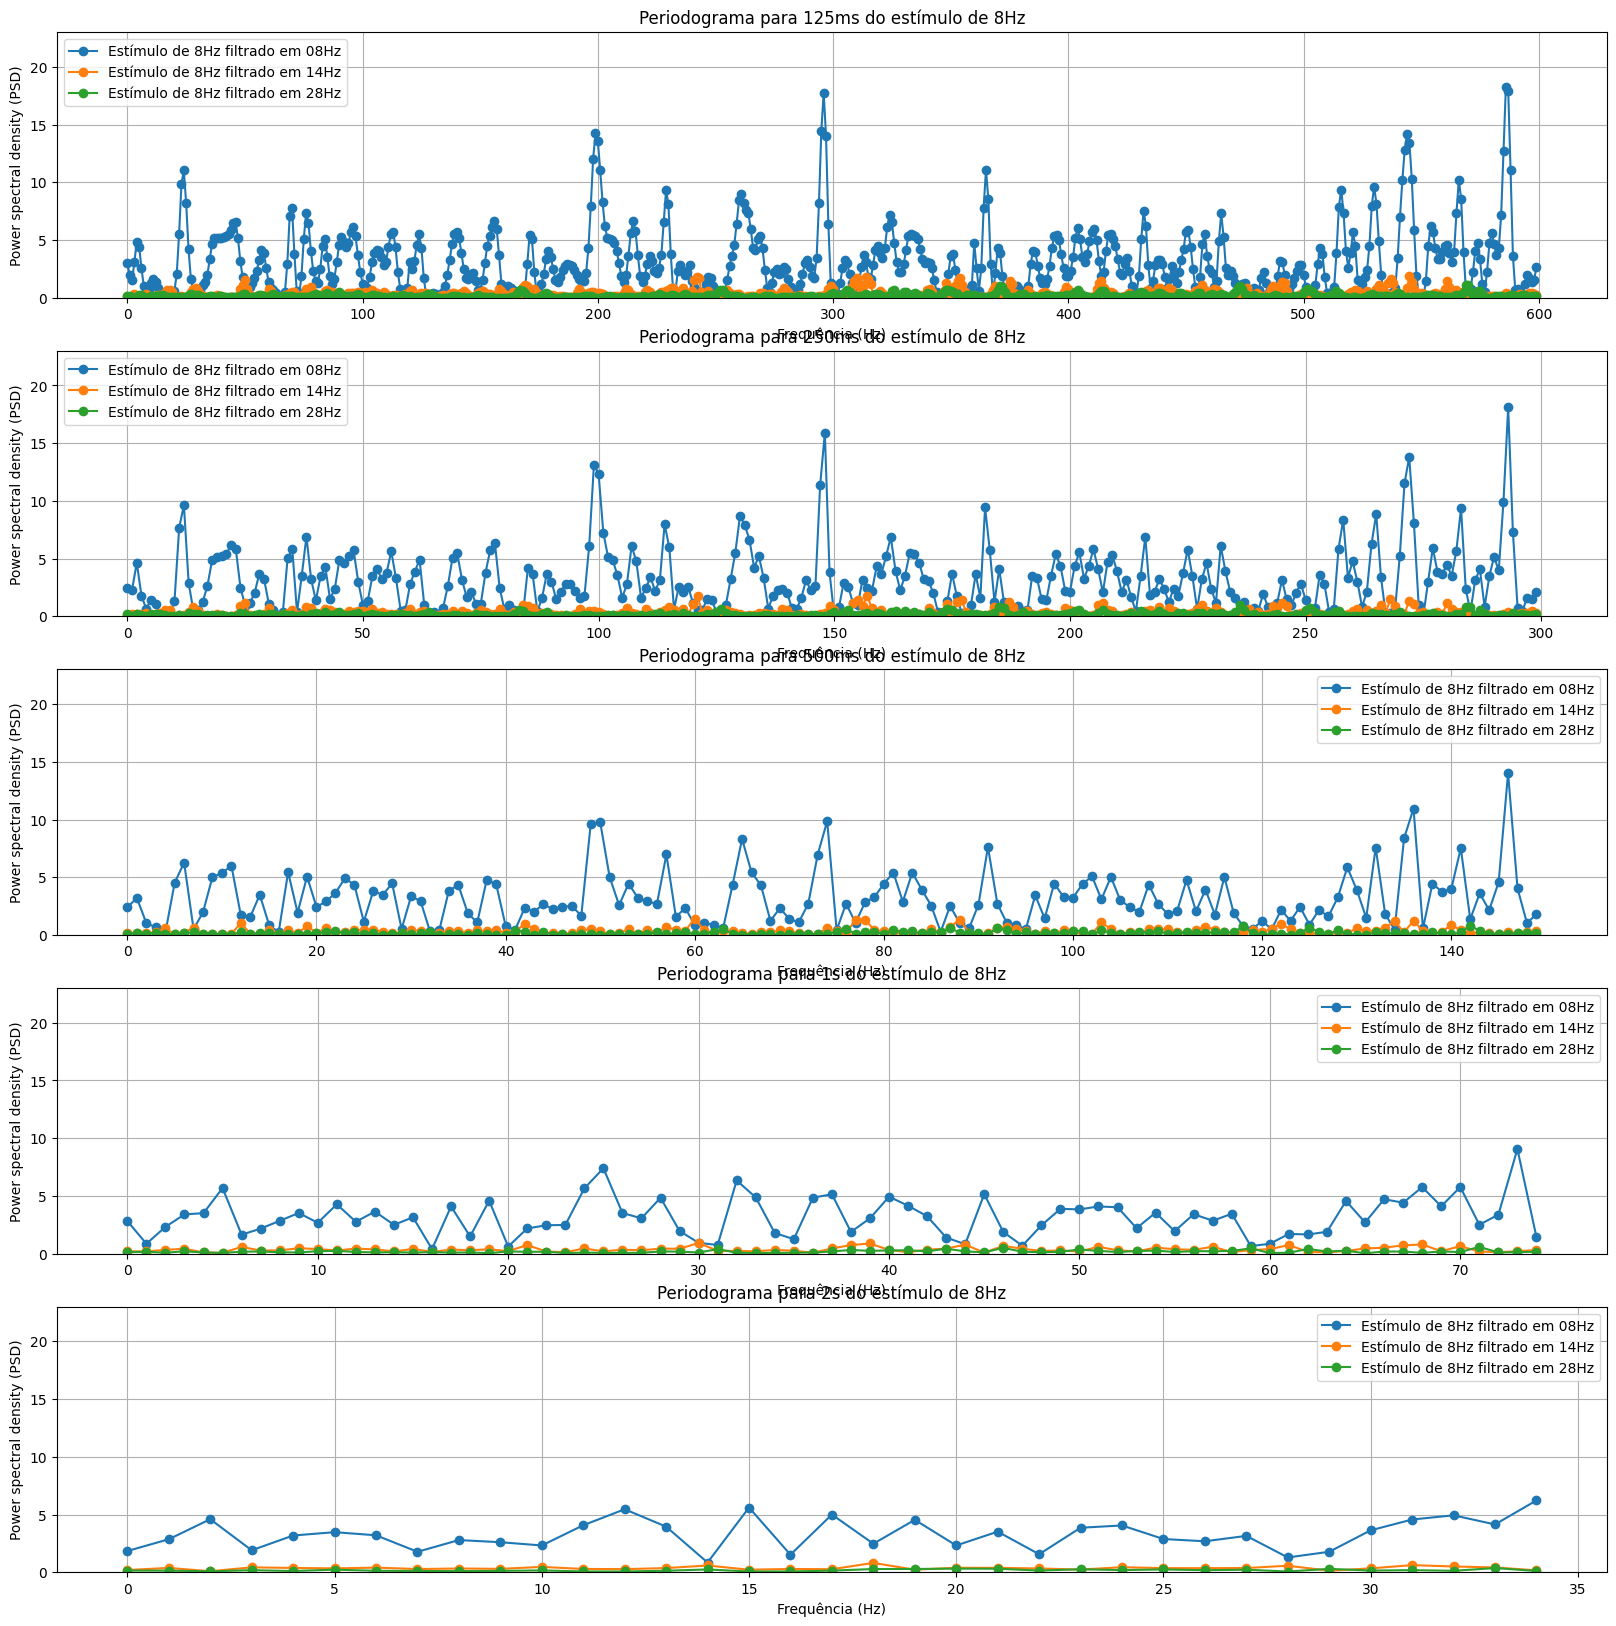

In [ ]:
plt.subplots(figsize=(20, 20))
plt.subplot(5, 1, 1)
plt.title('Periodograma para 125ms do estímulo de 8Hz')
plt.plot(power_125ms_8hz_filt_08Hz, '-o', label='Estímulo de 8Hz filtrado em 08Hz')
plt.plot(power_125ms_8hz_filt_14Hz, '-o', label='Estímulo de 8Hz filtrado em 14Hz')
plt.plot(power_125ms_8hz_filt_28Hz, '-o', label='Estímulo de 8Hz filtrado em 28Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Power spectral density (PSD)')
plt.legend()
plt.ylim(0, 23)
plt.grid()
plt.subplot(5, 1, 2)
plt.title('Periodograma para 250ms do estímulo de 8Hz')
plt.plot(power_250ms_8hz_filt_08Hz, '-o', label='Estímulo de 8Hz filtrado em 08Hz')
plt.plot(power_250ms_8hz_filt_14Hz, '-o', label='Estímulo de 8Hz filtrado em 14Hz')
plt.plot(power_250ms_8hz_filt_28Hz, '-o', label='Estímulo de 8Hz filtrado em 28Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Power spectral density (PSD)')
plt.legend()
plt.ylim(0, 23)
plt.grid()
plt.subplot(5, 1, 3)
plt.title('Periodograma para 500ms do estímulo de 8Hz')
plt.plot(power_500ms_8hz_filt_08Hz, '-o', label='Estímulo de 8Hz filtrado em 08Hz')
plt.plot(power_500ms_8hz_filt_14Hz, '-o', label='Estímulo de 8Hz filtrado em 14Hz')
plt.plot(power_500ms_8hz_filt_28Hz, '-o', label='Estímulo de 8Hz filtrado em 28Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Power spectral density (PSD)')
plt.legend()
plt.ylim(0, 23)
plt.grid()
plt.subplot(5, 1, 4)
plt.title('Periodograma para 1s do estímulo de 8Hz')
plt.plot(power_1s_8hz_filt_08Hz, '-o', label='Estímulo de 8Hz filtrado em 08Hz')
plt.plot(power_1s_8hz_filt_14Hz, '-o', label='Estímulo de 8Hz filtrado em 14Hz')
plt.plot(power_1s_8hz_filt_28Hz, '-o', label='Estímulo de 8Hz filtrado em 28Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Power spectral density (PSD)')
plt.legend()
plt.ylim(0, 23)
plt.grid()
plt.subplot(5, 1, 5)
plt.title('Periodograma para 2s do estímulo de 8Hz')
plt.plot(power_2s_8hz_filt_08Hz, '-o', label='Estímulo de 8Hz filtrado em 08Hz')
plt.plot(power_2s_8hz_filt_14Hz, '-o', label='Estímulo de 8Hz filtrado em 14Hz')
plt.plot(power_2s_8hz_filt_28Hz, '-o', label='Estímulo de 8Hz filtrado em 28Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Power spectral density (PSD)')
plt.legend()
plt.ylim(0, 23)
plt.grid()
plt.show()

## **Classificação**
No SSVEP, a etapa de classificação tem o objetivo de designar a frequência cujo usuário está focado.

### Classificação binária: 8Hz e 14Hz

#### Matriz de Features
> Foram obtidas diferentes quantidades de épocas para cada janela de tempo na extração de característica. Para realizar a classificação dos dados é necessário separá-los utilizando o método *holdout*, que consiste em dividir os dados em 70% para treinamento e 30% para teste. A classificação será feita a partir dos dados extraídos do canal Oz nas frequências de 8 Hz e 14 Hz.

In [ ]:
##=========== Matriz de Features para combinação 8Hz e 14Hz ========##

feature_8hz_125ms = np.vstack((power_125ms_8hz_filt_08Hz, power_125ms_8hz_filt_14Hz)) # Matriz de feature para frequência de 8Hz e época de 125ms
feature_14hz_125ms = np.vstack((power_125ms_14hz_filt_08Hz, power_125ms_14hz_filt_14Hz)) # Matriz de feature para frequência de 14Hz e época de 125ms

feature_8hz_250ms = np.vstack((power_250ms_8hz_filt_08Hz, power_250ms_8hz_filt_14Hz)) # Matriz de feature para frequência de 8Hz e época de 250ms
feature_14hz_250ms = np.vstack((power_250ms_14hz_filt_08Hz, power_250ms_14hz_filt_14Hz)) # Matriz de feature para frequência de 14Hz e época de 250ms

feature_8hz_500ms = np.vstack((power_500ms_8hz_filt_08Hz, power_500ms_8hz_filt_14Hz)) # Matriz de feature para frequência de 8Hz e época de 500ms
feature_14hz_500ms = np.vstack((power_500ms_14hz_filt_08Hz, power_500ms_14hz_filt_14Hz)) # Matriz de feature para frequência de 14Hz e época de 500ms

feature_8hz_1s = np.vstack((power_1s_8hz_filt_08Hz, power_1s_8hz_filt_14Hz)) # Matriz de feature para frequência de 8Hz e época de 1s
feature_14hz_1s = np.vstack((power_1s_14hz_filt_08Hz, power_1s_14hz_filt_14Hz)) # Matriz de feature para frequência de 14Hz e época de 1s

feature_8hz_2s = np.vstack((power_2s_8hz_filt_08Hz, power_2s_8hz_filt_14Hz)) # Matriz de feature para frequência de 8Hz e época de 1s
feature_14hz_2s = np.vstack((power_2s_14hz_filt_08Hz, power_2s_14hz_filt_14Hz)) # Matriz de feature para frequência de 14Hz e época de 1s

In [ ]:
print(feature_8hz_125ms.shape)
print(feature_8hz_250ms.shape)
print(feature_8hz_500ms.shape)
print(feature_8hz_1s.shape)
print(feature_8hz_2s.shape)

(2, 600)
(2, 300)
(2, 150)
(2, 75)
(2, 35)


In [ ]:
# Como é método de divisão consiste em uma separação de 70% dos dados para treino e 30% dos dados para teste. Foi adicionado essa divisão para cada época.

'''
  Sendo que os dados para a época de 125ms possui shape (2, 600)
  Correspondente à 2 frequências (8Hz e 14Hz) e 600 épocas para cada.
  70 % = 420 dos dados de 8Hz e 420 dos dados de 14Hz
  30% = 180 dos dados de 8Hz e 180 dos dados de 14Hz
'''
X_train_125ms = np.hstack((feature_8hz_125ms[:,:420],feature_14hz_125ms[:,:420]))
y_train_125ms = np.hstack((np.zeros(420),np.ones(420)))
X_test_125ms = np.hstack((feature_8hz_125ms[:,420:],feature_14hz_125ms[:,420:]))
y_test_125ms = np.hstack((np.zeros(180),np.ones(180)))

'''
  Sendo que os dados para a época de 250ms possui shape (2, 300)
  Correspondente à 2 frequências (8Hz e 14Hz) e 300 épocas para cada.
  70 % = 210 dos dados de 8Hz e 210 dos dados de 14Hz
  30% = 90 dos dados de 8Hz e 90 dos dados de 14Hz
'''
X_train_250ms = np.hstack((feature_8hz_250ms[:,:210],feature_14hz_250ms[:,:210]))
y_train_250ms = np.hstack((np.zeros(210),np.ones(210)))
X_test_250ms = np.hstack((feature_8hz_250ms[:,210:],feature_14hz_250ms[:,210:]))
y_test_250ms = np.hstack((np.zeros(90),np.ones(90)))

'''
  Sendo que os dados para a época de 500ms possui shape (2, 150)
  Correspondente à 2 frequências (8Hz e 14Hz) e 150 épocas para cada.
  70 % = 105 dos dados de 8Hz e 105 dos dados de 14Hz
  30% = 45 dos dados de 8Hz e 45 dos dados de 14Hz
'''
X_train_500ms = np.hstack((feature_8hz_500ms[:,:105],feature_14hz_500ms[:,:105]))
y_train_500ms = np.hstack((np.zeros(105),np.ones(105)))
X_test_500ms = np.hstack((feature_8hz_500ms[:,105:],feature_14hz_500ms[:,105:]))
y_test_500ms = np.hstack((np.zeros(45),np.ones(45)))

'''
  Sendo que os dados para a época de 1s possui shape (2, 75)
  Correspondente à 2 frequências (8Hz e 14Hz) e 75 épocas para cada.
  70 % = 50 dos dados de 8Hz e 50 dos dados de 14Hz
  30% = 25 dos dados de 8Hz e 25 dos dados de 14Hz
'''
X_train_1s = np.hstack((feature_8hz_1s[:,:50],feature_14hz_1s[:,:50]))
y_train_1s = np.hstack((np.zeros(50),np.ones(50)))
X_test_1s = np.hstack((feature_8hz_1s[:,50:],feature_14hz_1s[:,50:]))
y_test_1s = np.hstack((np.zeros(25),np.ones(25)))

'''
  Sendo que os dados para a época de 2s possui shape (2, 35)
  Correspondente à 2 frequências (8Hz e 14Hz) e 35 épocas para cada.
  70 % = 25 dos dados de 8Hz e 25 dos dados de 14Hz
  30% = 10 dos dados de 8Hz e 10 dos dados de 14Hz
'''
X_train_2s = np.hstack((feature_8hz_2s[:,:25],feature_14hz_2s[:,:25]))
y_train_2s = np.hstack((np.zeros(25),np.ones(25)))
X_test_2s = np.hstack((feature_8hz_2s[:,25:],feature_14hz_2s[:,25:]))
y_test_2s = np.hstack((np.zeros(10),np.ones(10)))

#### Analise do Discriminante Linear (LDA)

> Análise Discriminante Linear, é um algoritmo de aprendizado de máquina supervisionado utilizado para a tarefa de classificação. O LDA é usado para encontrar um conjunto de características que possam representar a separação ótima entre as classes do conjunto de dados. O objetivo do LDA é projetar as amostras de entrada em um espaço de menor dimensão, em que cada nova dimensão (chamada de discriminante) maximiza a separação entre as classes. Isso é feito encontrando os discriminantes que maximizam a razão entre a variância entre as classes e a variância dentro de cada classe.

> A classificação foi realizada por meio da função *LinearDiscriminantAnalysis*, aplicado no conjunto de dados já separado, que está contida na biblioteca *sklearn.discriminant_analysis*, para efetuar o treinamento do classificador utilizou-se a função *fit()*.





In [ ]:
lda = LinearDiscriminantAnalysis()

'''
  fit(X, y): Treina o modelo de Análise Discriminante Linear.
  Parâmetros:
    X (array): Dados de treinamento para cada época.
    y (array): Valores alvo.
  Retornos:
    Estimador ajustado.
  predict(X):
    Prevê rótulos de classe para amostras em X.
  Parâmetros:
    X (array): A matriz de dados para a qual queremos obter as previsões.
  Retornos:
    prever_epoca (array): Vetor contendo os rótulos de classe para cada amostra.
'''

lda.fit(X_train_125ms.T,y_train_125ms.T) # Treinando o classificador com época de 125ms
prever_125ms = lda.predict(X_test_125ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_250ms.T,y_train_250ms) # Treinando o classificador com época de 250ms
prever_250ms = lda.predict(X_test_250ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_500ms.T,y_train_500ms) # Treinando o classificador com época de 500ms
prever_500ms = lda.predict(X_test_500ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_1s.T,y_train_1s) # Treinando o classificador com época de 1s
prever_1s = lda.predict(X_test_1s.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_2s.T,y_train_2s) # Treinando o classificador com época de 1s
prever_2s = lda.predict(X_test_2s.T) # Realizando a previsão do meu classificador com os dados para teste


#### Metricas
> Acurácia: a acurácia é uma métrica usada para medir a precisão de um modelo de aprendizado de máquina na tarefa de classificação. Em outras palavras, a acurácia mede a proporção de previsões corretas feitas pelo modelo em relação ao total de previsões feitas. A fórmula para a acurácia é: acurácia = (número de previsões corretas) / (número total de previsões)

> Precisão: a precisão é uma métrica usada para medir a qualidade de um modelo de classificação na tarefa de prever as classes corretas. A precisão mede a proporção de exemplos positivos previstos corretamente em relação ao número total de exemplos previstos como positivos. A fórmula para a precisão é:
precisão = (verdadeiros positivos) / (verdadeiros positivos + falsos positivos)



In [ ]:
def calcular_metricas(classe_real, classe_predita):
    '''
      Calcula métricas de avaliação de classificação.

      Parâmetros:
        classe_real (array): Rótulos reais.
        classe_predita (array): Rótulos previstos pelo classificador.

      Devoluções:
        accuracy (float): Acurácia em porcentagem.
        precision (float): Precisão em porcentagem.
        recall (float): Recall em porcentagem.
        f1 (float): F1 Score em porcentagem.
        matriz_confusao (array): Matriz de confusão.
        acuracia_individual (array): Acurácia individual para cada rótulo em porcentagem.
    '''
    # Calcula as métricas usando funções do sklearn
    accuracy = accuracy_score(classe_real, classe_predita) * 100
    precision = precision_score(classe_real, classe_predita) * 100
    recall = recall_score(classe_real, classe_predita) * 100
    f1 = f1_score(classe_real, classe_predita) * 100
    matriz_confusao = confusion_matrix(classe_real, classe_predita)

    # Calcula a acurácia individual para cada rótulo
    acuracia_individual = matriz_confusao.diagonal() / matriz_confusao.sum(axis=1) * 100

    return accuracy, precision, recall, f1, matriz_confusao, acuracia_individual

# Definindo rótulos reais e previstos para cada época
classe_real_125ms = y_test_125ms.reshape(-1, 1)
classe_predita_125ms = prever_125ms

classe_real_250ms = y_test_250ms.reshape(-1, 1)
classe_predita_250ms = prever_250ms

classe_real_500ms = y_test_500ms.reshape(-1, 1)
classe_predita_500ms = prever_500ms

classe_real_1s = y_test_1s.reshape(-1, 1)
classe_predita_1s = prever_1s

classe_real_2s = y_test_2s.reshape(-1, 1)
classe_predita_2s = prever_2s

# Calculando métricas para 125ms
accuracy_125ms, precision_125ms, recall_125ms, f1_125ms, matriz_confusao_125ms, acuracia_individual_125ms = calcular_metricas(classe_real_125ms, classe_predita_125ms)

# Calculando métricas para 250ms
accuracy_250ms, precision_250ms, recall_250ms, f1_250ms, matriz_confusao_250ms, acuracia_individual_250ms = calcular_metricas(classe_real_250ms, classe_predita_250ms)

# Calculando métricas para 500ms
accuracy_500ms, precision_500ms, recall_500ms, f1_500ms, matriz_confusao_500ms, acuracia_individual_500ms = calcular_metricas(classe_real_500ms, classe_predita_500ms)

# Calculando métricas para 1s
accuracy_1s, precision_1s, recall_1s, f1_1s, matriz_confusao_1s, acuracia_individual_1s = calcular_metricas(classe_real_1s, classe_predita_1s)

# Calculando métricas para 2s
accuracy_2s, precision_2s, recall_2s, f1_2s, matriz_confusao_2s, acuracia_individual_2s = calcular_metricas(classe_real_2s, classe_predita_2s)

# Apresentando os resultados
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 125ms  | Accuracy     | ", round(accuracy_125ms, 2), "%")
print(" LDA:   | 125ms  | Precision    | ", round(precision_125ms, 2), "%")
print(" LDA:   | 125ms  | Recall       | ", round(recall_125ms, 2), "%")
print(" LDA:   | 125ms  | F1 Score     | ", round(f1_125ms, 2), "%")
print(" LDA:   | 125ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_125ms[0], 2), "%")
print(" LDA:   | 125ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_125ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 250ms  | Accuracy     | ", round(accuracy_250ms, 2), "%")
print(" LDA:   | 250ms  | Precision    | ", round(precision_250ms, 2), "%")
print(" LDA:   | 250ms  | Recall       | ", round(recall_250ms, 2), "%")
print(" LDA:   | 250ms  | F1 Score     | ", round(f1_250ms, 2), "%")
print(" LDA:   | 250ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_250ms[0], 2), "%")
print(" LDA:   | 250ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_250ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 500ms  | Accuracy     | ", round(accuracy_500ms, 2), "%")
print(" LDA:   | 500ms  | Precision    | ", round(precision_500ms, 2), "%")
print(" LDA:   | 500ms  | Recall       | ", round(recall_500ms, 2), "%")
print(" LDA:   | 500ms  | F1 Score     | ", round(f1_500ms, 2), "%")
print(" LDA:   | 500ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_500ms[0], 2), "%")
print(" LDA:   | 500ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_500ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   |   1s   | Accuracy     | ", round(accuracy_1s, 2), "%")
print(" LDA:   |   1s   | Precision    | ", round(precision_1s, 2), "%")
print(" LDA:   |   1s   | Recall       | ", round(recall_1s, 2), "%")
print(" LDA:   |   1s   | F1 Score     | ", round(f1_1s, 2), "%")
print(" LDA:   |   1s   | Matriz Conf. | Frequência 1: ", round(acuracia_individual_1s[0], 2), "%")
print(" LDA:   |   1s   | Matriz Conf. | Frequência 2: ", round(acuracia_individual_1s[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   |   2s   | Accuracy     | ", round(accuracy_2s, 2), "%")
print(" LDA:   |   2s   | Precision    | ", round(precision_2s, 2), "%")
print(" LDA:   |   2s   | Recall       | ", round(recall_2s, 2), "%")
print(" LDA:   |   2s   | F1 Score     | ", round(f1_2s, 2), "%")
print(" LDA:   |   2s   | Matriz Conf. | Frequência 1: ", round(acuracia_individual_2s[0], 2), "%")
print(" LDA:   |   2s   | Matriz Conf. | Frequência 2: ", round(acuracia_individual_2s[1], 2), "%")

MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 125ms  | Accuracy     |  68.33 %
 LDA:   | 125ms  | Precision    |  83.67 %
 LDA:   | 125ms  | Recall       |  45.56 %
 LDA:   | 125ms  | F1 Score     |  58.99 %
 LDA:   | 125ms  | Matriz Conf. | Frequência 1:  91.11 %
 LDA:   | 125ms  | Matriz Conf. | Frequência 2:  45.56 %


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 250ms  | Accuracy     |  68.33 %
 LDA:   | 250ms  | Precision    |  82.35 %
 LDA:   | 250ms  | Recall       |  46.67 %
 LDA:   | 250ms  | F1 Score     |  59.57 %
 LDA:   | 250ms  | Matriz Conf. | Frequência 1:  90.0 %
 LDA:   | 250ms  | Matriz Conf. | Frequência 2:  46.67 %


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 500ms  | Accuracy     |  73.33 %
 LDA:   | 500ms  | Precision    |  88.89 %
 LDA:   | 500ms  | Recall       |  53.33 %
 LDA:   | 500ms  | F1 Score     |  66.67 %
 LDA:   | 500ms  | Matriz Conf. | Frequência 1:  93.33 %
 LDA:   | 500ms  | Matriz Conf. | Frequência 2:  53.33 %


MODELO  | Tempo  

### Validação Cruzada
> A fórmula básica do k-fold cross-validation pode ser descrita da seguinte maneira:
1. Dividir os dados em k partes iguais.
2. Para cada iteração i de 1 a k: (a) Usar a parte i como conjunto de validação (ou teste) e as outras k-1 partes como conjunto de treinamento; (b) Treinar o modelo usando o conjunto de treinamento; (c) Avaliar o modelo usando o conjunto de validação e armazenar a métrica de desempenho (por exemplo, acurácia, erro médio quadrático, etc.).
3. Calcular a métrica de desempenho média e desvio padrão entre as k iterações.

Essa técnica é aplicada na modelagem de dados, que é especialmente útil quando há poucos dados disponíveis para treinamento, envolve a divisão do conjunto de dados em partes menores que são chamadas de *folds* e serve para treinar e testar o modelo em diferentes combinações. Para validação, com o conjunto de dados separado pelo método *holdout*, foi utilizada a função *cross_val_score()* presente na biblioteca *sklearn.model_selection*, o *cross-validation* (cv) foi definido como quinto e o treinamento foi realizado utilizando os classificadores: LDA e SVM.



In [ ]:
scores_125ms = cross_val_score(lda, X_test_125ms.T, y_test_125ms, cv=5, n_jobs=1)
scores_250ms = cross_val_score(lda, X_test_250ms.T, y_test_250ms, cv=5, n_jobs=1)
scores_500ms = cross_val_score(lda, X_test_500ms.T, y_test_500ms, cv=5, n_jobs=1)
scores_1s = cross_val_score(lda, X_test_1s.T, y_test_1s, cv=5, n_jobs=1)

print('LDA Accuracy epoch 0.125s: %.3f' % (np.mean(scores_125ms)))
print('LDA Accuracy epoch 0.250s: %.3f' % (np.mean(scores_250ms)))
print('LDA Accuracy epoch 0.500s: %.3f' % (np.mean(scores_500ms)))
print('LDA Accuracy epoch 1.000s: %.3f' % (np.mean(scores_1s)))

LDA Accuracy epoch 0.125s: 0.714
LDA Accuracy epoch 0.250s: 0.706
LDA Accuracy epoch 0.500s: 0.767
LDA Accuracy epoch 1.000s: 0.860


### Classificação binária: 8Hz e 28Hz

#### Matriz de Features
> Foram obtidas diferentes quantidades de épocas para cada janela de tempo na extração de característica. Para realizar a classificação dos dados é necessário separá-los utilizando o método *holdout*, que consiste em dividir os dados em 70% para treinamento e 30% para teste. A classificação será feita a partir dos dados extraídos do canal Oz nas frequências de 8 Hz e 28 Hz.

In [ ]:
# ##=========== Matriz de Features 8Hz e 28Hz ========##
feature_8hz_125ms = np.vstack((power_125ms_8hz_filt_08Hz, power_125ms_8hz_filt_28Hz)) # Matriz de feature para frequência de 8Hz e época de 125ms
feature_28hz_125ms = np.vstack((power_125ms_28hz_filt_08Hz, power_125ms_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 125ms

feature_8hz_250ms = np.vstack((power_250ms_8hz_filt_08Hz, power_250ms_8hz_filt_28Hz)) # Matriz de feature para frequência de 8Hz e época de 250ms
feature_28hz_250ms = np.vstack((power_250ms_28hz_filt_08Hz, power_250ms_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 250ms

feature_8hz_500ms = np.vstack((power_500ms_8hz_filt_08Hz, power_500ms_8hz_filt_28Hz)) # Matriz de feature para frequência de 8Hz e época de 500ms
feature_28hz_500ms = np.vstack((power_500ms_28hz_filt_08Hz, power_500ms_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 500ms

feature_8hz_1s = np.vstack((power_1s_8hz_filt_08Hz, power_1s_8hz_filt_28Hz)) # Matriz de feature para frequência de 8Hz e época de 1s
feature_28hz_1s = np.vstack((power_1s_28hz_filt_08Hz, power_1s_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 1s

feature_8hz_2s = np.vstack((power_2s_8hz_filt_08Hz, power_2s_8hz_filt_28Hz)) # Matriz de feature para frequência de 8Hz e época de 2s
feature_28hz_2s = np.vstack((power_2s_28hz_filt_08Hz, power_2s_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 2s


In [ ]:
# Como é método de divisão consiste em uma separação de 70% dos dados para treino e 30% dos dados para teste. Foi adicionado essa divisão para cada época.

'''
  Sendo que os dados para a época de 125ms possui shape (2, 600)
  Correspondente à 2 frequências (8Hz e 28Hz) e 600 épocas para cada.
  70 % = 420 dos dados de 8Hz e 420 dos dados de 28Hz
  30% = 180 dos dados de 8Hz e 180 dos dados de 28Hz
'''
X_train_125ms = np.hstack((feature_8hz_125ms[:,:420],feature_28hz_125ms[:,:420]))
y_train_125ms = np.hstack((np.zeros(420),np.ones(420)))
X_test_125ms = np.hstack((feature_8hz_125ms[:,420:],feature_28hz_125ms[:,420:]))
y_test_125ms = np.hstack((np.zeros(180),np.ones(180)))

'''
  Sendo que os dados para a época de 250ms possui shape (2, 300)
  Correspondente à 2 frequências (8Hz e 28Hz) e 300 épocas para cada.
  70 % = 210 dos dados de 8Hz e 210 dos dados de 28Hz
  30% = 90 dos dados de 8Hz e 90 dos dados de 28Hz
'''
X_train_250ms = np.hstack((feature_8hz_250ms[:,:210],feature_28hz_250ms[:,:210]))
y_train_250ms = np.hstack((np.zeros(210),np.ones(210)))
X_test_250ms = np.hstack((feature_8hz_250ms[:,210:],feature_28hz_250ms[:,210:]))
y_test_250ms = np.hstack((np.zeros(90),np.ones(90)))

'''
  Sendo que os dados para a época de 500ms possui shape (2, 150)
  Correspondente à 2 frequências (8Hz e 28Hz) e 150 épocas para cada.
  70 % = 105 dos dados de 8Hz e 105 dos dados de 28Hz
  30% = 45 dos dados de 8Hz e 45 dos dados de 28Hz
'''
X_train_500ms = np.hstack((feature_8hz_500ms[:,:105],feature_28hz_500ms[:,:105]))
y_train_500ms = np.hstack((np.zeros(105),np.ones(105)))
X_test_500ms = np.hstack((feature_8hz_500ms[:,105:],feature_28hz_500ms[:,105:]))
y_test_500ms = np.hstack((np.zeros(45),np.ones(45)))

'''
  Sendo que os dados para a época de 1s possui shape (2, 75)
  Correspondente à 2 frequências (8Hz e 28Hz) e 75 épocas para cada.
  70 % = 50 dos dados de 8Hz e 50 dos dados de 28Hz
  30% = 25 dos dados de 8Hz e 25 dos dados de 28Hz
'''
X_train_1s = np.hstack((feature_8hz_1s[:,:50],feature_28hz_1s[:,:50]))
y_train_1s = np.hstack((np.zeros(50),np.ones(50)))
X_test_1s = np.hstack((feature_8hz_1s[:,50:],feature_28hz_1s[:,50:]))
y_test_1s = np.hstack((np.zeros(25),np.ones(25)))

'''
  Sendo que os dados para a época de 2s possui shape (2, 35)
  Correspondente à 2 frequências (8Hz e 28Hz) e 35 épocas para cada.
  70 % = 25 dos dados de 8Hz e 25 dos dados de 28Hz
  30% = 10 dos dados de 8Hz e 10 dos dados de 28Hz
'''
X_train_2s = np.hstack((feature_8hz_2s[:,:25],feature_14hz_2s[:,:25]))
y_train_2s = np.hstack((np.zeros(25),np.ones(25)))
X_test_2s = np.hstack((feature_8hz_2s[:,25:],feature_14hz_2s[:,25:]))
y_test_2s = np.hstack((np.zeros(10),np.ones(10)))

#### Analise do Discriminante Linear (LDA)

> Análise Discriminante Linear, é um algoritmo de aprendizado de máquina supervisionado utilizado para a tarefa de classificação. O LDA é usado para encontrar um conjunto de características que possam representar a separação ótima entre as classes do conjunto de dados. O objetivo do LDA é projetar as amostras de entrada em um espaço de menor dimensão, em que cada nova dimensão (chamada de discriminante) maximiza a separação entre as classes. Isso é feito encontrando os discriminantes que maximizam a razão entre a variância entre as classes e a variância dentro de cada classe.

> A classificação foi realizada por meio da função *LinearDiscriminantAnalysis*, aplicado no conjunto de dados já separado, que está contida na biblioteca *sklearn.discriminant_analysis*, para efetuar o treinamento do classificador utilizou-se a função *fit()*.

In [ ]:
lda = LinearDiscriminantAnalysis()

'''
  fit(X, y): Treina o modelo de Análise Discriminante Linear.
  Parâmetros:
    X (array): Dados de treinamento para cada época.
    y (array): Valores alvo.
  Retornos:
    Estimador ajustado.
  predict(X):
    Prevê rótulos de classe para amostras em X.
  Parâmetros:
    X (array): A matriz de dados para a qual queremos obter as previsões.
  Retornos:
    prever_epoca (array): Vetor contendo os rótulos de classe para cada amostra.
'''

lda.fit(X_train_125ms.T,y_train_125ms.T) # Treinando o classificador com época de 125ms
prever_125ms = lda.predict(X_test_125ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_250ms.T,y_train_250ms) # Treinando o classificador com época de 250ms
prever_250ms = lda.predict(X_test_250ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_500ms.T,y_train_500ms) # Treinando o classificador com época de 500ms
prever_500ms = lda.predict(X_test_500ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_1s.T,y_train_1s) # Treinando o classificador com época de 1s
prever_1s = lda.predict(X_test_1s.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_2s.T,y_train_2s) # Treinando o classificador com época de 2s
prever_2s = lda.predict(X_test_2s.T) # Realizando a previsão do meu classificador com os dados para teste


#### Metricas
> Acurácia: a acurácia é uma métrica usada para medir a precisão de um modelo de aprendizado de máquina na tarefa de classificação. Em outras palavras, a acurácia mede a proporção de previsões corretas feitas pelo modelo em relação ao total de previsões feitas. A fórmula para a acurácia é: acurácia = (número de previsões corretas) / (número total de previsões)

> Precisão: a precisão é uma métrica usada para medir a qualidade de um modelo de classificação na tarefa de prever as classes corretas. A precisão mede a proporção de exemplos positivos previstos corretamente em relação ao número total de exemplos previstos como positivos. A fórmula para a precisão é:
precisão = (verdadeiros positivos) / (verdadeiros positivos + falsos positivos)



In [ ]:
def calcular_metricas(classe_real, classe_predita):
    '''
      Calcula métricas de avaliação de classificação.

      Parâmetros:
      - classe_real (array): Rótulos reais.
      - classe_predita (array): Rótulos previstos pelo classificador.

      Devoluções:
      - accuracy (float): Acurácia em porcentagem.
      - precision (float): Precisão em porcentagem.
      - recall (float): Recall em porcentagem.
      - f1 (float): F1 Score em porcentagem.
      - matriz_confusao (array): Matriz de confusão.
      - acuracia_individual (array): Acurácia individual para cada rótulo em porcentagem.
    '''
    # Calcula as métricas usando funções do sklearn
    accuracy = accuracy_score(classe_real, classe_predita) * 100
    precision = precision_score(classe_real, classe_predita) * 100
    recall = recall_score(classe_real, classe_predita) * 100
    f1 = f1_score(classe_real, classe_predita) * 100
    matriz_confusao = confusion_matrix(classe_real, classe_predita)

    # Calcula a acurácia individual para cada rótulo
    acuracia_individual = matriz_confusao.diagonal() / matriz_confusao.sum(axis=1) * 100

    return accuracy, precision, recall, f1, matriz_confusao, acuracia_individual

# Definindo rótulos reais e previstos para cada época
classe_real_125ms = y_test_125ms.reshape(-1, 1)
classe_predita_125ms = prever_125ms

classe_real_250ms = y_test_250ms.reshape(-1, 1)
classe_predita_250ms = prever_250ms

classe_real_500ms = y_test_500ms.reshape(-1, 1)
classe_predita_500ms = prever_500ms

classe_real_1s = y_test_1s.reshape(-1, 1)
classe_predita_1s = prever_1s

classe_real_2s = y_test_2s.reshape(-1, 1)
classe_predita_2s = prever_2s

# Calculando métricas para 125ms
accuracy_125ms, precision_125ms, recall_125ms, f1_125ms, matriz_confusao_125ms, acuracia_individual_125ms = calcular_metricas(classe_real_125ms, classe_predita_125ms)

# Calculando métricas para 250ms
accuracy_250ms, precision_250ms, recall_250ms, f1_250ms, matriz_confusao_250ms, acuracia_individual_250ms = calcular_metricas(classe_real_250ms, classe_predita_250ms)

# Calculando métricas para 500ms
accuracy_500ms, precision_500ms, recall_500ms, f1_500ms, matriz_confusao_500ms, acuracia_individual_500ms = calcular_metricas(classe_real_500ms, classe_predita_500ms)

# Calculando métricas para 1s
accuracy_1s, precision_1s, recall_1s, f1_1s, matriz_confusao_1s, acuracia_individual_1s = calcular_metricas(classe_real_1s, classe_predita_1s)

# Calculando métricas para 2s
accuracy_2s, precision_2s, recall_2s, f1_2s, matriz_confusao_2s, acuracia_individual_2s = calcular_metricas(classe_real_2s, classe_predita_2s)

# Apresentando os resultados
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 125ms  | Accuracy     | ", round(accuracy_125ms, 2), "%")
print(" LDA:   | 125ms  | Precision    | ", round(precision_125ms, 2), "%")
print(" LDA:   | 125ms  | Recall       | ", round(recall_125ms, 2), "%")
print(" LDA:   | 125ms  | F1 Score     | ", round(f1_125ms, 2), "%")
print(" LDA:   | 125ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_125ms[0], 2), "%")
print(" LDA:   | 125ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_125ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 250ms  | Accuracy     | ", round(accuracy_250ms, 2), "%")
print(" LDA:   | 250ms  | Precision    | ", round(precision_250ms, 2), "%")
print(" LDA:   | 250ms  | Recall       | ", round(recall_250ms, 2), "%")
print(" LDA:   | 250ms  | F1 Score     | ", round(f1_250ms, 2), "%")
print(" LDA:   | 250ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_250ms[0], 2), "%")
print(" LDA:   | 250ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_250ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 500ms  | Accuracy     | ", round(accuracy_500ms, 2), "%")
print(" LDA:   | 500ms  | Precision    | ", round(precision_500ms, 2), "%")
print(" LDA:   | 500ms  | Recall       | ", round(recall_500ms, 2), "%")
print(" LDA:   | 500ms  | F1 Score     | ", round(f1_500ms, 2), "%")
print(" LDA:   | 500ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_500ms[0], 2), "%")
print(" LDA:   | 500ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_500ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   |   1s   | Accuracy     | ", round(accuracy_1s, 2), "%")
print(" LDA:   |   1s   | Precision    | ", round(precision_1s, 2), "%")
print(" LDA:   |   1s   | Recall       | ", round(recall_1s, 2), "%")
print(" LDA:   |   1s   | F1 Score     | ", round(f1_1s, 2), "%")
print(" LDA:   |   1s   | Matriz Conf. | Frequência 1: ", round(acuracia_individual_1s[0], 2), "%")
print(" LDA:   |   1s   | Matriz Conf. | Frequência 2: ", round(acuracia_individual_1s[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   |   2s   | Accuracy     | ", round(accuracy_2s, 2), "%")
print(" LDA:   |   2s   | Precision    | ", round(precision_2s, 2), "%")
print(" LDA:   |   2s   | Recall       | ", round(recall_2s, 2), "%")
print(" LDA:   |   2s   | F1 Score     | ", round(f1_2s, 2), "%")
print(" LDA:   |   2s   | Matriz Conf. | Frequência 1: ", round(acuracia_individual_2s[0], 2), "%")
print(" LDA:   |   2s   | Matriz Conf. | Frequência 2: ", round(acuracia_individual_2s[1], 2), "%")


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 125ms  | Accuracy     |  68.89 %
 LDA:   | 125ms  | Precision    |  66.35 %
 LDA:   | 125ms  | Recall       |  76.67 %
 LDA:   | 125ms  | F1 Score     |  71.13 %
 LDA:   | 125ms  | Matriz Conf. | Frequência 1:  61.11 %
 LDA:   | 125ms  | Matriz Conf. | Frequência 2:  76.67 %


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 250ms  | Accuracy     |  71.11 %
 LDA:   | 250ms  | Precision    |  68.63 %
 LDA:   | 250ms  | Recall       |  77.78 %
 LDA:   | 250ms  | F1 Score     |  72.92 %
 LDA:   | 250ms  | Matriz Conf. | Frequência 1:  64.44 %
 LDA:   | 250ms  | Matriz Conf. | Frequência 2:  77.78 %


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 500ms  | Accuracy     |  77.78 %
 LDA:   | 500ms  | Precision    |  75.51 %
 LDA:   | 500ms  | Recall       |  82.22 %
 LDA:   | 500ms  | F1 Score     |  78.72 %
 LDA:   | 500ms  | Matriz Conf. | Frequência 1:  73.33 %
 LDA:   | 500ms  | Matriz Conf. | Frequência 2:  82.22 %


MODELO  | Tempo 

### Classificação binária: 14Hz e 28Hz

#### Matriz de Features
> Foram obtidas diferentes quantidades de épocas para cada janela de tempo na extração de característica. Para realizar a classificação dos dados é necessário separá-los utilizando o método *holdout*, que consiste em dividir os dados em 70% para treinamento e 30% para teste. A classificação será feita a partir dos dados extraídos do canal Oz nas frequências de 14 Hz e 28 Hz.

In [ ]:
# ##=========== Matriz de Features 14Hz e 28Hz ========##
feature_14hz_125ms = np.vstack((power_125ms_14hz_filt_14Hz, power_125ms_14hz_filt_28Hz)) # Matriz de feature para frequência de 14Hz e época de 125ms
feature_28hz_125ms = np.vstack((power_125ms_28hz_filt_14Hz, power_125ms_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 125ms

feature_14hz_250ms = np.vstack((power_250ms_14hz_filt_14Hz, power_250ms_14hz_filt_28Hz)) # Matriz de feature para frequência de 14Hz e época de 250ms
feature_28hz_250ms = np.vstack((power_250ms_28hz_filt_14Hz, power_250ms_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 250ms

feature_14hz_500ms = np.vstack((power_500ms_14hz_filt_14Hz, power_500ms_14hz_filt_28Hz)) # Matriz de feature para frequência de 14Hz e época de 500ms
feature_28hz_500ms = np.vstack((power_500ms_28hz_filt_14Hz, power_500ms_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 500ms

feature_14hz_1s = np.vstack((power_1s_14hz_filt_14Hz, power_1s_14hz_filt_28Hz)) # Matriz de feature para frequência de 14Hz e época de 1s
feature_28hz_1s = np.vstack((power_1s_28hz_filt_14Hz, power_1s_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 1s

feature_14hz_2s = np.vstack((power_2s_14hz_filt_14Hz, power_2s_14hz_filt_28Hz)) # Matriz de feature para frequência de 14Hz e época de 2s
feature_28hz_2s = np.vstack((power_2s_28hz_filt_14Hz, power_2s_28hz_filt_28Hz)) # Matriz de feature para frequência de 28Hz e época de 2s


In [ ]:
# Como é método de divisão consiste em uma separação de 70% dos dados para treino e 30% dos dados para teste. Foi adicionado essa divisão para cada época.

'''
  Sendo que os dados para a época de 125ms possui shape (2, 600)
  Correspondente à 2 frequências (14Hz e 28Hz) e 600 épocas para cada.
  70 % = 420 dos dados de 14Hz e 420 dos dados de 28Hz
  30% = 180 dos dados de 14Hz e 180 dos dados de 28Hz
'''
X_train_125ms = np.hstack((feature_14hz_125ms[:,:420],feature_28hz_125ms[:,:420]))
y_train_125ms = np.hstack((np.zeros(420),np.ones(420)))
X_test_125ms = np.hstack((feature_14hz_125ms[:,420:],feature_28hz_125ms[:,420:]))
y_test_125ms = np.hstack((np.zeros(180),np.ones(180)))

'''
  Sendo que os dados para a época de 250ms possui shape (2, 300)
  Correspondente à 2 frequências (14Hz e 28Hz) e 300 épocas para cada.
  70 % = 210 dos dados de 14Hz e 210 dos dados de 28Hz
  30% = 90 dos dados de 14Hz e 90 dos dados de 28Hz
'''
X_train_250ms = np.hstack((feature_14hz_250ms[:,:210],feature_28hz_250ms[:,:210]))
y_train_250ms = np.hstack((np.zeros(210),np.ones(210)))
X_test_250ms = np.hstack((feature_14hz_250ms[:,210:],feature_28hz_250ms[:,210:]))
y_test_250ms = np.hstack((np.zeros(90),np.ones(90)))

'''
  Sendo que os dados para a época de 500ms possui shape (2, 150)
  Correspondente à 2 frequências (14Hz e 28Hz) e 150 épocas para cada.
  70 % = 105 dos dados de 14Hz e 105 dos dados de 28Hz
  30% = 45 dos dados de 14Hz e 45 dos dados de 28Hz
'''
X_train_500ms = np.hstack((feature_14hz_500ms[:,:105],feature_28hz_500ms[:,:105]))
y_train_500ms = np.hstack((np.zeros(105),np.ones(105)))
X_test_500ms = np.hstack((feature_14hz_500ms[:,105:],feature_28hz_500ms[:,105:]))
y_test_500ms = np.hstack((np.zeros(45),np.ones(45)))

'''
  Sendo que os dados para a época de 1s possui shape (2, 75)
  Correspondente à 2 frequências (14Hz e 28Hz) e 75 épocas para cada.
  70 % = 50 dos dados de 14Hz e 50 dos dados de 28Hz
  30% = 25 dos dados de 14Hz e 25 dos dados de 28Hz
'''
X_train_1s = np.hstack((feature_14hz_1s[:,:50],feature_28hz_1s[:,:50]))
y_train_1s = np.hstack((np.zeros(50),np.ones(50)))
X_test_1s = np.hstack((feature_14hz_1s[:,50:],feature_28hz_1s[:,50:]))
y_test_1s = np.hstack((np.zeros(25),np.ones(25)))

'''
  Sendo que os dados para a época de 2s possui shape (2, 35)
  Correspondente à 2 frequências (14Hz e 28Hz) e 35 épocas para cada.
  70 % = 25 dos dados de 14Hz e 25 dos dados de 28Hz
  30% = 10 dos dados de 14Hz e 10 dos dados de 28Hz
'''
X_train_2s = np.hstack((feature_14hz_2s[:,:25],feature_28hz_2s[:,:25]))
y_train_2s = np.hstack((np.zeros(25),np.ones(25)))
X_test_2s = np.hstack((feature_14hz_2s[:,25:],feature_28hz_2s[:,25:]))
y_test_2s = np.hstack((np.zeros(10),np.ones(10)))

#### Analise do Discriminante Linear (LDA)

> Análise Discriminante Linear, é um algoritmo de aprendizado de máquina supervisionado utilizado para a tarefa de classificação. O LDA é usado para encontrar um conjunto de características que possam representar a separação ótima entre as classes do conjunto de dados. O objetivo do LDA é projetar as amostras de entrada em um espaço de menor dimensão, em que cada nova dimensão (chamada de discriminante) maximiza a separação entre as classes. Isso é feito encontrando os discriminantes que maximizam a razão entre a variância entre as classes e a variância dentro de cada classe.

> A classificação foi realizada por meio da função *LinearDiscriminantAnalysis*, aplicado no conjunto de dados já separado, que está contida na biblioteca *sklearn.discriminant_analysis*, para efetuar o treinamento do classificador utilizou-se a função *fit()*.

In [ ]:
lda = LinearDiscriminantAnalysis()

'''
  fit(X, y): Treina o modelo de Análise Discriminante Linear.
  Parâmetros:
    X (array): Dados de treinamento para cada época.
    y (array): Valores alvo.
  Retornos:
    Estimador ajustado.
  predict(X):
    Prevê rótulos de classe para amostras em X.
  Parâmetros:
    X (array): A matriz de dados para a qual queremos obter as previsões.
  Retornos:
    prever_epoca (array): Vetor contendo os rótulos de classe para cada amostra.
'''

lda.fit(X_train_125ms.T,y_train_125ms.T) # Treinando o classificador com época de 125ms
prever_125ms = lda.predict(X_test_125ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_250ms.T,y_train_250ms) # Treinando o classificador com época de 250ms
prever_250ms = lda.predict(X_test_250ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_500ms.T,y_train_500ms) # Treinando o classificador com época de 500ms
prever_500ms = lda.predict(X_test_500ms.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_1s.T,y_train_1s) # Treinando o classificador com época de 1s
prever_1s = lda.predict(X_test_1s.T) # Realizando a previsão do meu classificador com os dados para teste

lda.fit(X_train_2s.T,y_train_2s) # Treinando o classificador com época de 2s
prever_2s = lda.predict(X_test_2s.T) # Realizando a previsão do meu classificador com os dados para teste


#### Metricas
> Acurácia: a acurácia é uma métrica usada para medir a precisão de um modelo de aprendizado de máquina na tarefa de classificação. Em outras palavras, a acurácia mede a proporção de previsões corretas feitas pelo modelo em relação ao total de previsões feitas. A fórmula para a acurácia é: acurácia = (número de previsões corretas) / (número total de previsões)

> Precisão: a precisão é uma métrica usada para medir a qualidade de um modelo de classificação na tarefa de prever as classes corretas. A precisão mede a proporção de exemplos positivos previstos corretamente em relação ao número total de exemplos previstos como positivos. A fórmula para a precisão é:
precisão = (verdadeiros positivos) / (verdadeiros positivos + falsos positivos)



In [ ]:
def calcular_metricas(classe_real, classe_predita):
    '''
      Calcula métricas de avaliação de classificação.

      Parâmetros:
      - classe_real (array): Rótulos reais.
      - classe_predita (array): Rótulos previstos pelo classificador.

      Devoluções:
      - accuracy (float): Acurácia em porcentagem.
      - precision (float): Precisão em porcentagem.
      - recall (float): Recall em porcentagem.
      - f1 (float): F1 Score em porcentagem.
      - matriz_confusao (array): Matriz de confusão.
      - acuracia_individual (array): Acurácia individual para cada rótulo em porcentagem.
    '''
    # Calcula as métricas usando funções do sklearn
    accuracy = accuracy_score(classe_real, classe_predita) * 100
    precision = precision_score(classe_real, classe_predita) * 100
    recall = recall_score(classe_real, classe_predita) * 100
    f1 = f1_score(classe_real, classe_predita) * 100
    matriz_confusao = confusion_matrix(classe_real, classe_predita)

    # Calcula a acurácia individual para cada rótulo
    acuracia_individual = matriz_confusao.diagonal() / matriz_confusao.sum(axis=1) * 100

    return accuracy, precision, recall, f1, matriz_confusao, acuracia_individual

# Definindo rótulos reais e previstos para cada época
classe_real_125ms = y_test_125ms.reshape(-1, 1)
classe_predita_125ms = prever_125ms

classe_real_250ms = y_test_250ms.reshape(-1, 1)
classe_predita_250ms = prever_250ms

classe_real_500ms = y_test_500ms.reshape(-1, 1)
classe_predita_500ms = prever_500ms

classe_real_1s = y_test_1s.reshape(-1, 1)
classe_predita_1s = prever_1s

classe_real_2s = y_test_2s.reshape(-1, 1)
classe_predita_2s = prever_2s

# Calculando métricas para 125ms
accuracy_125ms, precision_125ms, recall_125ms, f1_125ms, matriz_confusao_125ms, acuracia_individual_125ms = calcular_metricas(classe_real_125ms, classe_predita_125ms)

# Calculando métricas para 250ms
accuracy_250ms, precision_250ms, recall_250ms, f1_250ms, matriz_confusao_250ms, acuracia_individual_250ms = calcular_metricas(classe_real_250ms, classe_predita_250ms)

# Calculando métricas para 500ms
accuracy_500ms, precision_500ms, recall_500ms, f1_500ms, matriz_confusao_500ms, acuracia_individual_500ms = calcular_metricas(classe_real_500ms, classe_predita_500ms)

# Calculando métricas para 1s
accuracy_1s, precision_1s, recall_1s, f1_1s, matriz_confusao_1s, acuracia_individual_1s = calcular_metricas(classe_real_1s, classe_predita_1s)

# Calculando métricas para 2s
accuracy_2s, precision_2s, recall_2s, f1_2s, matriz_confusao_2s, acuracia_individual_2s = calcular_metricas(classe_real_2s, classe_predita_2s)

# Apresentando os resultados
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 125ms  | Accuracy     | ", round(accuracy_125ms, 2), "%")
print(" LDA:   | 125ms  | Precision    | ", round(precision_125ms, 2), "%")
print(" LDA:   | 125ms  | Recall       | ", round(recall_125ms, 2), "%")
print(" LDA:   | 125ms  | F1 Score     | ", round(f1_125ms, 2), "%")
print(" LDA:   | 125ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_125ms[0], 2), "%")
print(" LDA:   | 125ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_125ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 250ms  | Accuracy     | ", round(accuracy_250ms, 2), "%")
print(" LDA:   | 250ms  | Precision    | ", round(precision_250ms, 2), "%")
print(" LDA:   | 250ms  | Recall       | ", round(recall_250ms, 2), "%")
print(" LDA:   | 250ms  | F1 Score     | ", round(f1_250ms, 2), "%")
print(" LDA:   | 250ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_250ms[0], 2), "%")
print(" LDA:   | 250ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_250ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   | 500ms  | Accuracy     | ", round(accuracy_500ms, 2), "%")
print(" LDA:   | 500ms  | Precision    | ", round(precision_500ms, 2), "%")
print(" LDA:   | 500ms  | Recall       | ", round(recall_500ms, 2), "%")
print(" LDA:   | 500ms  | F1 Score     | ", round(f1_500ms, 2), "%")
print(" LDA:   | 500ms  | Matriz Conf. | Frequência 1: ", round(acuracia_individual_500ms[0], 2), "%")
print(" LDA:   | 500ms  | Matriz Conf. | Frequência 2: ", round(acuracia_individual_500ms[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   |   1s   | Accuracy     | ", round(accuracy_1s, 2), "%")
print(" LDA:   |   1s   | Precision    | ", round(precision_1s, 2), "%")
print(" LDA:   |   1s   | Recall       | ", round(recall_1s, 2), "%")
print(" LDA:   |   1s   | F1 Score     | ", round(f1_1s, 2), "%")
print(" LDA:   |   1s   | Matriz Conf. | Frequência 1: ", round(acuracia_individual_1s[0], 2), "%")
print(" LDA:   |   1s   | Matriz Conf. | Frequência 2: ", round(acuracia_individual_1s[1], 2), "%")
print("\n")
print("MODELO  | Tempo  | Métrica      | Valor")
print(" LDA:   |   2s   | Accuracy     | ", round(accuracy_2s, 2), "%")
print(" LDA:   |   2s   | Precision    | ", round(precision_2s, 2), "%")
print(" LDA:   |   2s   | Recall       | ", round(recall_2s, 2), "%")
print(" LDA:   |   2s   | F1 Score     | ", round(f1_2s, 2), "%")
print(" LDA:   |   2s   | Matriz Conf. | Frequência 1: ", round(acuracia_individual_2s[0], 2), "%")
print(" LDA:   |   2s   | Matriz Conf. | Frequência 2: ", round(acuracia_individual_2s[1], 2), "%")


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 125ms  | Accuracy     |  63.61 %
 LDA:   | 125ms  | Precision    |  58.72 %
 LDA:   | 125ms  | Recall       |  91.67 %
 LDA:   | 125ms  | F1 Score     |  71.58 %
 LDA:   | 125ms  | Matriz Conf. | Frequência 1:  35.56 %
 LDA:   | 125ms  | Matriz Conf. | Frequência 2:  91.67 %


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 250ms  | Accuracy     |  62.22 %
 LDA:   | 250ms  | Precision    |  57.75 %
 LDA:   | 250ms  | Recall       |  91.11 %
 LDA:   | 250ms  | F1 Score     |  70.69 %
 LDA:   | 250ms  | Matriz Conf. | Frequência 1:  33.33 %
 LDA:   | 250ms  | Matriz Conf. | Frequência 2:  91.11 %


MODELO  | Tempo  | Métrica      | Valor
 LDA:   | 500ms  | Accuracy     |  63.33 %
 LDA:   | 500ms  | Precision    |  58.57 %
 LDA:   | 500ms  | Recall       |  91.11 %
 LDA:   | 500ms  | F1 Score     |  71.3 %
 LDA:   | 500ms  | Matriz Conf. | Frequência 1:  35.56 %
 LDA:   | 500ms  | Matriz Conf. | Frequência 2:  91.11 %


MODELO  | Tempo  